# Data

In [1]:
import csv
import datetime
import glob

import pickle
import scipy.sparse
import time
import zipfile 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

sns.set_style('whitegrid')
sns.set_palette('pastel')
sns.set_context('poster')
#sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')

# Initial code found in https://github.com/eleijonmarck/DDSC/blob/master/src/dsc/dsc.py

## **Import data: REFIT**

In [4]:
with open('data/refit_data_by_category.pk', 'rb') as f:
    data = pickle.load(f)
    
train, test = data['train'], data['test']

# **Algorithms**

In [37]:
from __future__ import division
import numpy as np
import pandas as pd
import time
#import librosa
import pickle
from sklearn.decomposition import SparseCoder,DictionaryLearning, sparse_encode
from sklearn.model_selection import GridSearchCV
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt
import itertools


class DSC():
    def __init__(self, X, general_params, nnsc_params, dd_params, transfer_params=None):
        """
        Args:
            The args are "X, m, T, general_params, nnsc_params, dd_params"
            
            X: training data - List
            #m: number of rows - int
            #T: number of columns (houses) - int
            
            general_params - Dict:
                weeks_to_train - int: number of subsets of data to use, by weekly subset
                rp - float: regularization parameter for SC (and DD) training (sparsity penalty)
                max_iter - int: maximum iter for the SparseCoder function in the Objective function F_obj

            nnsc_params - Dict:
                gradient_step_size (mu) - float: gradient step size for SC
                steps - int: steps for SC training
                epsilon - float: tolerance level for SC training
                n - int: number of hidden components
                
            dd_params - Dict:
                dd_mu - float: gradient step size for DD
                dd_steps - int: steps for DD training
                dd_epsilon - float: tolerance level for DD training
            
            
        """
        self.X = X
        
        self.weeks_to_train = general_params['weeks_to_train']
        self.rp = general_params['rp']
        self.max_iter = general_params['max_iter']
        
        
        self.mu = nnsc_params['gradient_step_size']
        self.steps = nnsc_params['steps']
        self.epsilon = nnsc_params['epsilon']
        self.n = nnsc_params['n_components']
        
        #self.m = m
        #self.T = T
        
        self.dd_steps = dd_params['dd_steps']
        self.dd_epsilon = dd_params['dd_epsilon']
        self.dd_mu = dd_params['dd_mu']

        if transfer_params:
          self.a = transfer_params['a']
          self.b = transfer_params['b']


################################################################
# will initiualize the matrices A,B with positive values and scale
# columns of B s.t b(j) = 1
    def _initialization(self):
      
        a = np.random.random((self.n,self.m))
        b = np.random.random((self.T,self.n))

        # scale columns s.t. b_i^(j) = 1
        b /= sum(b)
        return a,b

    def nnsc_obj_error(self,x, Ap, Bp):
      #print('Ap', Ap)
      #print(np.dot(Bp, Ap))
      return np.linalg.norm(np.dot(Bp, Ap)-x, 2)

    def pre_training(self,x,enable_transfer_learning=False,coral=False):
        # TODO : implement s.t. conditions and frobenius norm to the options
        tic = time.time()
        #the NON NEGATIVE SPARSE CODING (or TSC)
        Ap, Bp ,errors = self.nnsc(enable_transfer_learning,coral)

        tac = time.time()
        t = tac - tic
        print('time of computations for Dictionary Learning with m: {} and T: {} took: {}'.format(self.m,self.T,t))
        return Ap, Bp ,errors
################################################################
    # using only the positive values, this is used for projected gradient descent
    @staticmethod
    def _constraint_for_basis_matrix(a):
        indices = np.where(a < 0.0)
        a[indices] = 0.0
        return a
#################################################################
    def nnsc(self, enable_transfer_learning, coral=False):
        '''
        Method as in NNSC from nonnegative sparse coding from P.Hoyer
        TODO:
        Also create multiple ndarrays that we take the argmin for.
        '''
        errors = []
        # used for F
        A_list = []
        B_list = []
        for ind in range(self.weeks_to_train):

            one_X = self.X.copy()[ind].values
            self.T, self.m = one_X.shape
            Ap, Bp = self._initialization()
            Ap1 = Ap
            Bp1 = Bp
            t = 0
            sparse_matrix_variation = 1

            target_ind = ['target' in x for x in train[0]['X_bar']].index(True)
            if enable_transfer_learning:# or True:
              # Initialize MMD and GL matrices
              S = np.zeros((self.m, self.m))
              N_s, N_t = target_ind, self.m - target_ind
              S[: target_ind, :target_ind] = 1/N_s**2
              S[target_ind:, target_ind:] = 1/N_t**2
              S[target_ind:, :target_ind] = -1/(N_s*N_t)
              S[: target_ind, target_ind:] = -1/(N_s*N_t)
              #print('S', S)
              K = kneighbors_graph(one_X.T, n_neighbors=3).todense()
              L = np.diag(np.sum(K, axis=1))
              L = np.sum(K, axis=1)
              U = K
              for i in range(U.shape[0]):
                U[i, i] = U[i, i] - L[i]

              S_tilde = self.a * S + self.b * U
              S_tilde[S_tilde<0] = 0

            # algo for NNSC

            err_iter = []

            while t <= self.steps and self.epsilon <= sparse_matrix_variation:
                # 2a
                Bp = Bp - self.mu*np.dot((np.dot(Bp,Ap) - one_X),Ap.T)
                # 2b
                Bp = self._constraint_for_basis_matrix(Bp)
                # 2c
                Bp /= sum(Bp)
                # element wise division
                if not enable_transfer_learning: #SC, no transfer
                  dot2 = np.divide(np.dot(Bp.T,one_X),(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp))
                  # 2d
                  Ap = np.multiply(Ap,dot2)
                else: #TSC, transfer using MMD and GL
                  transfer_update = np.dot(Ap, (S_tilde + S_tilde.T)) #Check this

                  if t % (self.steps // 5) == 0:
                    print('\n norms:', np.linalg.norm(transfer_update), np.linalg.norm(Ap), 'rapport ', np.linalg.norm(transfer_update)/np.linalg.norm(Ap))
                    print('MMD term ', np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))), '\n')
                                    
                  dot2 = np.divide(np.dot(Bp.T,one_X),(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp + transfer_update))

                  # 2d
                  Ap = np.multiply(Ap,dot2)

                sparse_matrix_variation = np.linalg.norm(Ap - Ap1)
                basis_matrix_variation = np.linalg.norm(Bp - Bp1)
                Ap1 = Ap
                Bp1 = Bp
                
                #if t%100==0:
                err_iter.append(self.nnsc_obj_error(one_X, Ap, Bp))
                if t%(self.steps//5)==0:
                    print("NNSC variation for A is {} for iter {}, and B variation is {}".format(sparse_matrix_variation,t, basis_matrix_variation))
                if t%(self.steps//50)==0:
                    print("Current objective function value is ", self.nnsc_obj_error(one_X, Ap, Bp))
                    if enable_transfer_learning:# or True:
                      print("Current TSC component value is ", np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))))
                t += 1


            print("\n Last step is {}, NNSC variation for A is {}, and B variation is {} \n".format(t, sparse_matrix_variation, basis_matrix_variation))
            if enable_transfer_learning:# or True:
              print('Final MMD term ', np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))), '\n')

            errors.append(err_iter)
            A_list.append(Ap)
            B_list.append(Bp)
            
        return A_list, B_list, errors


#################################################################
    def F_obj(self,x,B,x_train=None,A=None,rp_tep=False,rp_gl=False, max_iter=30000):
        '''
        input is lists of the elements
        output list of elements
        '''
        # 4b
        B = np.asarray(B)
        A = np.asarray(A)
        if self.max_iter:
            max_iter = self.max_iter

        acts = sparse_encode(x.T, B.T, algorithm='lasso_cd', alpha=self.rp, positive=True, max_iter=max_iter).T
        acts = self._constraint_for_basis_matrix(acts)
        return acts
#################################################################
    def DD(self,x_bar,B,A):
        '''
        Taking the parameters as x_train_use and discriminate over the
        entire region
        '''
        # 3.
        A_star = np.vstack(A)
        B_cat = np.hstack(B)
        print('A_star has a shape of {}, B_cat has a shape of {}'.format(A_star.shape, B_cat.shape))
        change = 1
        t = 0
        acc_disag = []

        err_disag = []
        print("Initial difference between x_bar and current solution ", 
            np.linalg.norm(x_bar - np.dot(B_cat, A_star)), '\n')
        while t < self.dd_steps and self.dd_epsilon <= change:
            t1=time.time()
            B_cat_p = B_cat
            # 4a
            acts = self.F_obj(x_bar,B_cat,A=A_star)
            t2=time.time()
            # 4b
            B_cat = (B_cat-self.dd_mu*((x_bar-B_cat.dot(acts))
                     .dot(acts.T) - (x_bar-B_cat.dot(A_star)).dot(A_star.T)))
            t3=time.time()
            # 4c
            # scale columns s.t. b_i^(j) = 1
            B_cat = self._constraint_for_basis_matrix(B_cat)
            t4=time.time()
            B_cat /= sum(B_cat)
            acts = self.F_obj(x_bar,B_cat)
            err_disag.append(np.linalg.norm(x_bar - np.dot(B_cat, acts)))
            
            # convergence check
            change = np.linalg.norm(B_cat - B_cat_p)
            
            if t%(self.steps//20)==0:
                print("DD change for B is {} and step is {}".format(change,t))
                print("Norm of A ", np.linalg.norm(acts))
                print("difference between x_bar and current solution", err_disag[-1])
            t += 1

        print('final step is {}, B change is {}, A norm is {}, difference between current_solution and X_bar is {} \n \n'.format(t, change, np.linalg.norm(acts), err_disag[-1]))
        self.acc_ddsc = acc_disag
        self.err_disag = err_disag

        return B_cat, err_disag
 
#################################################################
    def predict(self,A,B):
        x = map(lambda x,y: x.dot(y),B,A)
        return x
#################################################################


# train block for DSC

In [23]:
##REFIT data
general_params = {'weeks_to_train': 2, 'rp': 0.3, 'max_iter': 4000}
nnsc_params = {'gradient_step_size': 10**(-8), 'epsilon': 0.2, 'steps': 4001, 'n_components': 25}
dd_params = {'dd_steps': 30, 'dd_epsilon': 10**(-3), 'dd_mu': 10**(-6)}

transfer_params = {'a': 0.02, 'b': 0.01}

In [24]:
def target_source_split_houses(df, subset='target', split=False, keep_target=False):
  """
  Created to be able to train on differet subsets to compare omitting target from keeping it
  """
  if not split:
    return df
  if keep_target:
    cols_to_extract = [x for x in df.columns if subset in x]
    target_index = ['target' in x for x in df.columns.tolist()].index(True)
    df = df[cols_to_extract]
    return df

  cols_to_extract = [x for x in df.columns if subset not in x]
  df = df[cols_to_extract]  
  return df

In [25]:
weeks_to_train = general_params['weeks_to_train']
weeks_to_test = weeks_to_train
appliance_categories = list(train[0]['X'].keys())

def nnsc_train_block(split, enable_transfer_learning=False, keep_target=False, coral=False):
    res = []
  
    for appliance_category in appliance_categories:
        x_train = [target_source_split_houses(train[week]['X'][appliance_category], split=split, keep_target=keep_target) for week in range(weeks_to_train)]
        x_bar_train = [target_source_split_houses(train[week]['X_bar'], split=split, keep_target=keep_target) for week in range(weeks_to_train)]  
        print('houses that exist in this data', list(x_bar_train[0].columns))

        x_test = [test[week]['X'][appliance_category] for week in range(weeks_to_test)]
        x_bar_test = [test[week]['X_bar'] for week in range(weeks_to_test)]

        train_set = x_train
        test_set = x_test

        # Discriminative Sparse Coding pre_training
        dsc = DSC(train_set, general_params, nnsc_params, dd_params, transfer_params)

        print("started the pre-training for", appliance_category)
        res.append(dsc.pre_training(x_train, enable_transfer_learning, coral))
        print("done pre_training")
        
    A_list = [x[0] for x in res]
    A_list = np.array(A_list)
    B_list = [x[1] for x in res]
    B_list = np.array(B_list)
    errors = [x[2] for x in res]

    return A_list, B_list, errors, dsc

**NNSC on source+target**

In [27]:
t0 = time.time()

A_list, B_list, errors, dsc = nnsc_train_block(split=False)

print('all SC pre-training took {} seconds'.format(round(time.time() - t0, 2)))

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
started the pre-training for fridge
NNSC variation for A is 2285.0019453645154 for iter 0, and B variation is 0.00019895576357553387
Current objective function value is  3362.0472922887484
Current objective function value is  78.5169514574591
Current objective function value is  38.54619113323347
Current objective function value is  27.16204177598513
Current objective function value is  21.769161631991995
Current objective function value is  18.253538325370627
Current objective function value is  15.879851526525126
Current objective function value is  14.21547023054998
Current objective function value is  12.984921705464531
Current objective function value is  12.106889362120954
NNSC variation for A is 4.783185116078623 for iter 800, and B variation is 0.0001434325126245267

Current objective function value is  107.1905295777916
Current objective function value is  107.1882026824285
Current objective function value is  107.18779016187237
Current objective function value is  107.18761216274416
Current objective function value is  107.18751091235896
NNSC variation for A is 0.24131484251101007 for iter 1600, and B variation is 0.00011849420887996005
Current objective function value is  107.18744582922511
Current objective function value is  107.18740165469626

 Last step is 1719, NNSC variation for A is 0.19995406995854553, and B variation is 9.294137431555799e-05 

NNSC variation for A is 2008.902336774476 for iter 0, and B variation is 0.0004693387839371331
Current objective function value is  6943.011961622703
Current objective function value is  976.6113727870602
Current objective function value is  973.378490093607
Current objective function value is  966.6744886854445
Current objective function value is  683.1554660732164
Current objective function valu

Current objective function value is  7.092576752014757
Current objective function value is  7.092696028814253
Current objective function value is  7.093010544854734
Current objective function value is  7.093534169879639
Current objective function value is  7.094238564404833
Current objective function value is  7.095095070953101
Current objective function value is  7.096079447655315
Current objective function value is  7.097171060268663
Current objective function value is  7.098352276613294
NNSC variation for A is 0.7207210103404262 for iter 4000, and B variation is 1.3422953131507188e-05
Current objective function value is  7.099607984276306

 Last step is 4002, NNSC variation for A is 0.7204961288321747, and B variation is 1.3416780858628957e-05 

time of computations for Dictionary Learning with m: 13 and T: 168 took: 0.8101680278778076
done pre_training
houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2

**NNSC on source, DD on target**

In [229]:
t0 = time.time()

A_list_source_only, B_list_source_only, errors_source_only, dsc_source_only = nnsc_train_block(split=True, keep_target=False)

print('all SC pre-training took {} seconds'.format(round(time.time() - t0, 2)))

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9']
started the pre-training for fridge
NNSC variation for A is 1796.6057710115292 for iter 0, and B variation is 0.00013746849343668975
Current objective function value is  2667.4398457390066
Current objective function value is  64.35150383781915
Current objective function value is  37.53365303815026
Current objective function value is  25.769044611330553
Current objective function value is  19.590804534614374
Current objective function value is  15.932084066760066
Current objective function value is  13.590754193593476
Current objective function value is  12.014409110706907
Current objective function value is  10.913715772407855
Current objective function value is  10.145028051333965
NNSC variation for A is 3.52216479286952 for iter 800, and B variation is 0.00011334749697741588
Current objective function value is  9.618181827691117
Current objective function value i

Current objective function value is  5.488576303381764
Current objective function value is  5.530500325612511
Current objective function value is  5.570310967333593
Current objective function value is  5.606702740751316
Current objective function value is  5.639106233782321
Current objective function value is  5.668648943794427
NNSC variation for A is 1.9392195487020514 for iter 2400, and B variation is 4.7862108468429066e-05
Current objective function value is  5.6953167027148535
Current objective function value is  5.718247283933159
Current objective function value is  5.737386464913989
Current objective function value is  5.754337352751733
Current objective function value is  5.769506004310167
Current objective function value is  5.78386667442938
Current objective function value is  5.7967795233992625
Current objective function value is  5.8085272370605185
Current objective function value is  5.820155937037162
Current objective function value is  5.832732584286132
NNSC variation for

Current objective function value is  5.68895377100342
NNSC variation for A is 0.8092123902455302 for iter 4000, and B variation is 1.7721555837627737e-05
Current objective function value is  5.692413556908537

 Last step is 4002, NNSC variation for A is 0.8089559302685764, and B variation is 1.7715165935035957e-05 

NNSC variation for A is 1896.8883095171059 for iter 0, and B variation is 0.00015320176123616698
Current objective function value is  2859.295154982926
Current objective function value is  49.76118337158346
Current objective function value is  23.873046293402993
Current objective function value is  16.23792463796678
Current objective function value is  12.628158542269896
Current objective function value is  10.562560999533975
Current objective function value is  9.251158142394631
Current objective function value is  8.371666741458904
Current objective function value is  7.755637057900233
Current objective function value is  7.30449344335339
NNSC variation for A is 4.3438737

Current objective function value is  7.415363643116835
Current objective function value is  7.240039658650087
Current objective function value is  7.096438451776117
Current objective function value is  6.988910218622796
Current objective function value is  6.915497026649532
NNSC variation for A is 1.4055264566375276 for iter 2400, and B variation is 4.090923856027634e-05
Current objective function value is  6.869959604558846
Current objective function value is  6.844139987371047
Current objective function value is  6.833857126939009
Current objective function value is  6.833746192518939
Current objective function value is  6.841965293111734
Current objective function value is  6.855036133711981
Current objective function value is  6.8699795499174865
Current objective function value is  6.884982712542593
Current objective function value is  6.899071343211534
Current objective function value is  6.911837293735767
NNSC variation for A is 0.9483861424079099 for iter 3200, and B variation i

Current objective function value is  50.79645148285903
Current objective function value is  27.992384979098844
Current objective function value is  20.517730163182822
Current objective function value is  16.7762879634868
Current objective function value is  14.619675147321189
Current objective function value is  13.251749623950664
Current objective function value is  12.299827848855376
Current objective function value is  11.577829256018047
Current objective function value is  10.979488130111896
NNSC variation for A is 3.51505442163552 for iter 800, and B variation is 0.00011812966300010173
Current objective function value is  10.445376348077653
Current objective function value is  9.944384273372771
Current objective function value is  9.46656303335817
Current objective function value is  9.000577002952678
Current objective function value is  8.552310891727814
Current objective function value is  8.12904221015816
Current objective function value is  7.740219672620082
Current objective 

Current objective function value is  4.925461807848989
Current objective function value is  4.931621324959607
Current objective function value is  4.95056019765255
NNSC variation for A is 0.6771359541474826 for iter 2400, and B variation is 4.163569022619284e-05
Current objective function value is  4.976464812549282
Current objective function value is  5.006102257957385
Current objective function value is  5.036900440154538
Current objective function value is  5.067933788097755
Current objective function value is  5.098415096865116
Current objective function value is  5.128345683240597
Current objective function value is  5.157306755906059
Current objective function value is  5.184842575957214
Current objective function value is  5.211288073193523
Current objective function value is  5.236571188745156
NNSC variation for A is 0.44584351525277366 for iter 3200, and B variation is 2.8188279512391113e-05
Current objective function value is  5.260704021113522
Current objective function valu

Current objective function value is  19.595110523383514
Current objective function value is  15.581830026711302
Current objective function value is  13.255221123296694
Current objective function value is  11.77378073666462
Current objective function value is  10.745109516223506
Current objective function value is  9.954405242353783
Current objective function value is  9.287492935572319
NNSC variation for A is 2.1279618931299695 for iter 800, and B variation is 0.00010580499441891596
Current objective function value is  8.687523682032179
Current objective function value is  8.126505617356381
Current objective function value is  7.593030267187673
Current objective function value is  7.0917898444787095
Current objective function value is  6.6388047345213295
Current objective function value is  6.2580034548427355
Current objective function value is  5.962372016005172
Current objective function value is  5.748067116904497
Current objective function value is  5.605796712293838
Current object

Current objective function value is  4.91980037133165
NNSC variation for A is 0.45213502512299464 for iter 2400, and B variation is 2.9854008973306614e-05
Current objective function value is  4.937850575131957
Current objective function value is  4.956281576163604
Current objective function value is  4.974791654405729
Current objective function value is  4.993192026688799
Current objective function value is  5.011359865367732
Current objective function value is  5.029215307188511
Current objective function value is  5.046705939342409
Current objective function value is  5.063801969554288
Current objective function value is  5.080487181718042
Current objective function value is  5.096756880345892
NNSC variation for A is 0.3262028126788927 for iter 3200, and B variation is 2.2396824695287213e-05
Current objective function value is  5.112615363768759
Current objective function value is  5.12807397040352
Current objective function value is  5.143149492732473
Current objective function valu

Current objective function value is  15.414105804083777
Current objective function value is  11.723189064969871
Current objective function value is  9.516313640278382
Current objective function value is  8.06560449178705
Current objective function value is  7.057544789272367
Current objective function value is  6.363883452504123
Current objective function value is  6.010469006698446
NNSC variation for A is 1.9191254766579218 for iter 800, and B variation is 0.00010182246967248625
Current objective function value is  5.837018456585536
Current objective function value is  5.71911643378991
Current objective function value is  5.625514837550451
Current objective function value is  5.5458671610934145
Current objective function value is  5.473217908076608
Current objective function value is  5.403104607959003
Current objective function value is  5.333356291341926
Current objective function value is  5.264050146072773
Current objective function value is  5.197236513890034
Current objective fu

Current objective function value is  5.19208190159945
Current objective function value is  5.20724747160682
NNSC variation for A is 0.3962002196445841 for iter 2400, and B variation is 3.0058100318261733e-05
Current objective function value is  5.221070684414809
Current objective function value is  5.233671919691826
Current objective function value is  5.2451609227482345
Current objective function value is  5.255637614186559
Current objective function value is  5.265193200481698
Current objective function value is  5.2739106338945145
Current objective function value is  5.28186542586492
Current objective function value is  5.289126412729122
Current objective function value is  5.295756065692511
Current objective function value is  5.301811209487545
NNSC variation for A is 0.2728823738440311 for iter 3200, and B variation is 2.1016315732484204e-05
Current objective function value is  5.307343545747727
Current objective function value is  5.3124000098104425
Current objective function val

Current objective function value is  4.660092494854734
Current objective function value is  4.711540576877507
Current objective function value is  4.758172550463765
Current objective function value is  4.799990198407633
Current objective function value is  4.837738817210818
Current objective function value is  4.871869211511105
NNSC variation for A is 0.9938848489052539 for iter 1600, and B variation is 4.656076362222853e-05
Current objective function value is  4.902633401672337
Current objective function value is  4.93038944813111
Current objective function value is  4.955741547157767
Current objective function value is  4.978966215118992
Current objective function value is  5.000272028474209
Current objective function value is  5.019801089357675
Current objective function value is  5.037691022305902
Current objective function value is  5.054171972387046
Current objective function value is  5.069442680655027
Current objective function value is  5.083628360476242
NNSC variation for A i

Current objective function value is  6.891407177310274
Current objective function value is  6.555580652512606
NNSC variation for A is 2.140221929879449 for iter 800, and B variation is 9.954041837436452e-05
Current objective function value is  6.304069465981852
Current objective function value is  6.116457222776346
Current objective function value is  5.975249225780239
Current objective function value is  5.87232271914319
Current objective function value is  5.795948686238353
Current objective function value is  5.737654656401657
Current objective function value is  5.693703853920364
Current objective function value is  5.658734856536087
Current objective function value is  5.630146495357943
Current objective function value is  5.60562997583159
NNSC variation for A is 1.2930147634272409 for iter 1600, and B variation is 5.9075386880070975e-05
Current objective function value is  5.5830148733902965
Current objective function value is  5.560317756222199
Current objective function value i

Current objective function value is  4.623963374342929
Current objective function value is  4.6292498835285985
Current objective function value is  4.635071221434153
Current objective function value is  4.640688392107675
Current objective function value is  4.645784383091332
Current objective function value is  4.65017961853863
NNSC variation for A is 0.4987246545627628 for iter 3200, and B variation is 2.7991017042099567e-05
Current objective function value is  4.6537689418114425
Current objective function value is  4.656496363313354
Current objective function value is  4.658366534907742
Current objective function value is  4.659442610155508
Current objective function value is  4.65984812073446
Current objective function value is  4.6597631614235215
Current objective function value is  4.659416008293637
Current objective function value is  4.65906699417305
Current objective function value is  4.658985969576295
Current objective function value is  4.659426727432519
NNSC variation for A

NNSC variation for A is 2.5373581464228248 for iter 800, and B variation is 0.00010293432785402503
Current objective function value is  7.495398679105337
Current objective function value is  7.083147196785072
Current objective function value is  6.743165852062943
Current objective function value is  6.460737589751984
Current objective function value is  6.225885346024194
Current objective function value is  6.030383252457912
Current objective function value is  5.8668730511264435
Current objective function value is  5.73219991707347
Current objective function value is  5.623838575522685
Current objective function value is  5.538491405954425
NNSC variation for A is 1.723582330210846 for iter 1600, and B variation is 5.589068461724501e-05
Current objective function value is  5.4723498694254635
Current objective function value is  5.421711174101602
Current objective function value is  5.3836334508330586
Current objective function value is  5.355890939325444
Current objective function valu

Current objective function value is  28.001446987386235
Current objective function value is  26.12238240151138
Current objective function value is  24.66014790786836

 Last step is 1072, NNSC variation for A is 0.19978358186361975, and B variation is 0.00015235381333505787 

NNSC variation for A is 1649.001792693295 for iter 0, and B variation is 0.0003596329559663175
Current objective function value is  9124.63127047158
Current objective function value is  101.96031618288742
Current objective function value is  72.02941218662872
Current objective function value is  72.01331546101817
Current objective function value is  71.99614232974638
Current objective function value is  71.9740801300017
Current objective function value is  71.94461258250996
Current objective function value is  71.90431384156548
Current objective function value is  71.84831035282737
Current objective function value is  71.76951906308584
NNSC variation for A is 0.25637345977168324 for iter 800, and B variation is 4.9

Current objective function value is  22.250656785258837
Current objective function value is  20.966432382953553
Current objective function value is  19.82931475948571
Current objective function value is  18.806392738241225
Current objective function value is  17.878628984242503
NNSC variation for A is 17.05527747470286 for iter 1600, and B variation is 0.0024060522054782196
Current objective function value is  17.035415246076187
Current objective function value is  16.270731025483745
Current objective function value is  15.580634178073817
Current objective function value is  14.961777873516196
Current objective function value is  14.41064534119335
Current objective function value is  13.923240223251044
Current objective function value is  13.495026740018577
Current objective function value is  13.12100531267704
Current objective function value is  12.795843631262638
Current objective function value is  12.514009189834043
NNSC variation for A is 11.333445904360193 for iter 2400, and B v

NNSC variation for A is 0.4292637555199628 for iter 4000, and B variation is 4.285481214942184e-05
Current objective function value is  80.64058798569648

 Last step is 4002, NNSC variation for A is 0.4292786307718378, and B variation is 4.285150856877576e-05 

NNSC variation for A is 2547.7815817577293 for iter 0, and B variation is 0.0004902995007211393
Current objective function value is  9530.07265219313
Current objective function value is  954.3320728951761
Current objective function value is  254.84190567838283
Current objective function value is  165.4397463819867
Current objective function value is  142.7055288259219
Current objective function value is  132.39131780573604
Current objective function value is  126.45449516237036
Current objective function value is  123.41500898572056
Current objective function value is  122.41776925889582
Current objective function value is  122.37508595731364
NNSC variation for A is 62.60163551740786 for iter 800, and B variation is 0.0173261244

Current objective function value is  655.2910756046805
Current objective function value is  651.5494476134693
Current objective function value is  647.0795915417267
Current objective function value is  639.8579525804378
NNSC variation for A is 1198.1910774540613 for iter 800, and B variation is 0.08640465928067322
Current objective function value is  628.4149815703844
Current objective function value is  615.2521329890739
Current objective function value is  600.2318132907191
Current objective function value is  583.702361893552
Current objective function value is  566.4311286964797
Current objective function value is  547.2236061398019
Current objective function value is  525.0647567754434
Current objective function value is  499.1236974070897
Current objective function value is  468.5664663037344
Current objective function value is  432.52933129135766
NNSC variation for A is 904.3628182775677 for iter 1600, and B variation is 0.0564863467128082
Current objective function value is  39

Current objective function value is  762.6173662146108
Current objective function value is  761.644179311531
Current objective function value is  760.8875516865608
NNSC variation for A is 342.49021974572656 for iter 800, and B variation is 0.10908652962717744
Current objective function value is  760.3188254514499
Current objective function value is  759.8775450382044
Current objective function value is  759.5482775186526
Current objective function value is  759.3029860904021
Current objective function value is  759.1155311662538
Current objective function value is  759.0054416653563
Current objective function value is  758.9639747490114
Current objective function value is  758.9486870434922
Current objective function value is  758.9432786009949
Current objective function value is  758.9291967689494
NNSC variation for A is 313.0957747354839 for iter 1600, and B variation is 0.10850164724930063
Current objective function value is  758.8778005155115
Current objective function value is  75

Current objective function value is  3035.9527232512346
Current objective function value is  3033.7572683922554
Current objective function value is  3031.7801289322774
Current objective function value is  3029.9913955376646
Current objective function value is  3028.3637937015824
Current objective function value is  3026.871753869314
Current objective function value is  3025.497170707309
NNSC variation for A is 1455.8284328628004 for iter 1600, and B variation is 0.44208582881518305
Current objective function value is  3024.2267938673976
Current objective function value is  3023.0558424227374
Current objective function value is  3021.9748071492068
Current objective function value is  3020.9752455589505
Current objective function value is  3020.2216017134206
Current objective function value is  3020.0631376265464
Current objective function value is  3020.3151721670342
Current objective function value is  3020.499473428449
Current objective function value is  3020.3255617019768
Current ob

Current objective function value is  455.2853297844067
NNSC variation for A is 80.55011465494901 for iter 3200, and B variation is 0.03375595504594096
Current objective function value is  455.2833229833084
Current objective function value is  455.2817380201074
Current objective function value is  455.28051104998934
Current objective function value is  455.27958685585776
Current objective function value is  455.27891775100744
Current objective function value is  455.27846262205793
Current objective function value is  455.27818616617856
Current objective function value is  455.27805818776125
Current objective function value is  455.27805294823725
Current objective function value is  455.2781485703228
NNSC variation for A is 63.26296869473287 for iter 4000, and B variation is 0.031974497846606546
Current objective function value is  455.2783264935009

 Last step is 4002, NNSC variation for A is 63.277041802612445, and B variation is 0.03197554486482488 

NNSC variation for A is 2724.21367

NNSC variation for A is 292.68034091188355 for iter 4000, and B variation is 0.01779116851347723
Current objective function value is  103.25490164367652

 Last step is 4002, NNSC variation for A is 292.6736925256556, and B variation is 0.01779119144378468 

NNSC variation for A is 2522.000248448579 for iter 0, and B variation is 0.00046924933255303294
Current objective function value is  9180.405575370616
Current objective function value is  705.9045109092118
Current objective function value is  439.4563167326413
Current objective function value is  337.38893237776495
Current objective function value is  282.27242749696364
Current objective function value is  249.1315331201043
Current objective function value is  227.61658901787402
Current objective function value is  218.82296492304047
Current objective function value is  218.28984456662255
Current objective function value is  217.61032621208048
NNSC variation for A is 69.42195783584279 for iter 800, and B variation is 0.0265864163291

Current objective function value is  49.87568820093343
Current objective function value is  43.94690328670828
NNSC variation for A is 0.9236939007942792 for iter 800, and B variation is 8.282135136037927e-05
Current objective function value is  39.14133698046019
Current objective function value is  35.203937798543336
Current objective function value is  31.939009802339854
Current objective function value is  29.199324862829965
Current objective function value is  26.87442558261335
Current objective function value is  24.880991177259947
Current objective function value is  23.15558688772037
Current objective function value is  21.649380144748065
Current objective function value is  20.324352441531783
Current objective function value is  19.15055915431696
NNSC variation for A is 0.22092385056742614 for iter 1600, and B variation is 2.575149953725846e-05
Current objective function value is  18.10415818325451
Current objective function value is  17.16596967955796

 Last step is 1687, NNSC 

Current objective function value is  5.9244093869302175
Current objective function value is  5.935509950377711
Current objective function value is  5.9470019711544255
NNSC variation for A is 0.5596766691085326 for iter 4000, and B variation is 1.5716494834589055e-05
Current objective function value is  5.958899667193838

 Last step is 4002, NNSC variation for A is 0.5595393862469917, and B variation is 1.5711433478273447e-05 

NNSC variation for A is 981.5047362550672 for iter 0, and B variation is 8.575813478513373e-05
Current objective function value is  1658.0738947375028
Current objective function value is  141.18154821088433
Current objective function value is  72.03656717783359
Current objective function value is  34.081024558508936
Current objective function value is  19.518466349005276
Current objective function value is  11.845023618895944
Current objective function value is  7.826113769648034
Current objective function value is  6.004636437841838
Current objective function va

Current objective function value is  7.148076950164451
Current objective function value is  6.9627515071786545
Current objective function value is  6.824632370745179
Current objective function value is  6.717734032900337
Current objective function value is  6.632224046403637
Current objective function value is  6.561878098276446
Current objective function value is  6.5026469511274
Current objective function value is  6.451825077062446
Current objective function value is  6.407555647514495
NNSC variation for A is 1.4539884015380338 for iter 1600, and B variation is 4.836862325691367e-05
Current objective function value is  6.368529152884271
Current objective function value is  6.333796337316938
Current objective function value is  6.302650068618788
Current objective function value is  6.274549524656289
Current objective function value is  6.249070755835057
Current objective function value is  6.225873913428343
Current objective function value is  6.204681143875169
Current objective func

Current objective function value is  6.025647467645364
Current objective function value is  6.030424873679768
Current objective function value is  6.035008444611927
Current objective function value is  6.039406620100355
Current objective function value is  6.043627388397662
NNSC variation for A is 1.1581197695766365 for iter 3200, and B variation is 2.0141716829517567e-05
Current objective function value is  6.047678316546289
Current objective function value is  6.051566577637758
Current objective function value is  6.055298975763108
Current objective function value is  6.058881969121322
Current objective function value is  6.062321691638661
Current objective function value is  6.065623973344982
Current objective function value is  6.068794359667406
Current objective function value is  6.071838129739629
Current objective function value is  6.074760313785452
Current objective function value is  6.077565709589678
NNSC variation for A is 0.829807533769232 for iter 4000, and B variation is

Current objective function value is  6.284344106755322
Current objective function value is  6.127821148947321
Current objective function value is  5.988198280023402
Current objective function value is  5.876183743233979
Current objective function value is  5.798839731319847
Current objective function value is  5.754393558662613
Current objective function value is  5.735522094697379
Current objective function value is  5.734161193317206
NNSC variation for A is 1.7364838176933601 for iter 1600, and B variation is 5.8080110387055636e-05
Current objective function value is  5.7441099737078885
Current objective function value is  5.761211703556222
Current objective function value is  5.78276671507783
Current objective function value is  5.8069950420554886
Current objective function value is  5.8326394862317406
Current objective function value is  5.858834383522636
Current objective function value is  5.8849627796932475
Current objective function value is  5.910612940110038
Current objective

Current objective function value is  5.589579457182894
NNSC variation for A is 0.3949649328100943 for iter 3200, and B variation is 2.0370118197402617e-05
Current objective function value is  5.590257983835979
Current objective function value is  5.5909453012897155
Current objective function value is  5.591634320788384
Current objective function value is  5.59231859274123
Current objective function value is  5.592992560224538
Current objective function value is  5.593651626725622
Current objective function value is  5.59429213200216
Current objective function value is  5.594911283578965
Current objective function value is  5.595507068896714
Current objective function value is  5.596077929990489
NNSC variation for A is 0.29345826030218464 for iter 4000, and B variation is 1.5201520730042677e-05
Current objective function value is  5.596622503840079

 Last step is 4002, NNSC variation for A is 0.29336840104106593, and B variation is 1.5196444825719218e-05 

NNSC variation for A is 1120.0

Current objective function value is  6.03697703513618
Current objective function value is  6.013014665081983
Current objective function value is  5.9958971159324905
Current objective function value is  5.983309641892098
Current objective function value is  5.973926414078666
NNSC variation for A is 1.5188429639385976 for iter 1600, and B variation is 4.3545017100674105e-05
Current objective function value is  5.966796342022325
Current objective function value is  5.96124830569739
Current objective function value is  5.956972473499289
Current objective function value is  5.953628491498157
Current objective function value is  5.951113071399177
Current objective function value is  5.949127875152699
Current objective function value is  5.947600522985783
Current objective function value is  5.946576258213112
Current objective function value is  5.945935373884084
Current objective function value is  5.945685049757119
NNSC variation for A is 0.8976209216250899 for iter 2400, and B variation is

Current objective function value is  5.1290933644882015
NNSC variation for A is 0.27965497279922463 for iter 3200, and B variation is 1.6682201382344134e-05
Current objective function value is  5.1302263528924295
Current objective function value is  5.131296556107158
Current objective function value is  5.132322907816122
Current objective function value is  5.133304717089107
Current objective function value is  5.134250651823507
Current objective function value is  5.135169634215791
Current objective function value is  5.136064105431611
Current objective function value is  5.136935160018227
Current objective function value is  5.137783599352889
Current objective function value is  5.138610138291145

 Last step is 3998, NNSC variation for A is 0.19998303228704495, and B variation is 1.2382283171123424e-05 

NNSC variation for A is 955.938645805026 for iter 0, and B variation is 9.652364711341314e-05
Current objective function value is  1743.5281489660367
Current objective function value

Current objective function value is  5.8503832724809275
Current objective function value is  5.84941692951759
Current objective function value is  5.852383986470756
Current objective function value is  5.859784205660932
Current objective function value is  5.871409669692449
Current objective function value is  5.886449988530642
Current objective function value is  5.904006180945351
Current objective function value is  5.92307786188287
NNSC variation for A is 0.5098885985082102 for iter 2400, and B variation is 3.597557764405708e-05
Current objective function value is  5.94259227037572
Current objective function value is  5.961686455189814
Current objective function value is  5.979918708995625
Current objective function value is  5.996729352983977
Current objective function value is  6.011731994908674
Current objective function value is  6.025052262648499
Current objective function value is  6.035158613523214
Current objective function value is  6.039081641169811
Current objective funct

Current objective function value is  6.218812727012703
Current objective function value is  6.208245932952774
Current objective function value is  6.1985997017635714
Current objective function value is  6.189779125759553
Current objective function value is  6.181700310668793
Current objective function value is  6.174289199332784
NNSC variation for A is 0.4370324121169974 for iter 4000, and B variation is 1.8767710471768448e-05
Current objective function value is  6.167480089910419

 Last step is 4002, NNSC variation for A is 0.43681645364935323, and B variation is 1.8763482643666037e-05 

NNSC variation for A is 894.4748734106736 for iter 0, and B variation is 8.356006531550498e-05
Current objective function value is  1557.3772724824282
Current objective function value is  142.35659204572565
Current objective function value is  25.865229179671214
Current objective function value is  10.236301484429148
Current objective function value is  7.2406877001695955
Current objective function va

Current objective function value is  5.150017413162652
Current objective function value is  5.159588550153582
Current objective function value is  5.168402744389564
Current objective function value is  5.176555499384218
Current objective function value is  5.1841437704015325
Current objective function value is  5.191225862077006
Current objective function value is  5.197843153354692
NNSC variation for A is 0.4324917060612559 for iter 2400, and B variation is 1.3667660973365047e-05
Current objective function value is  5.204038160460195
Current objective function value is  5.2098450688887015
Current objective function value is  5.215286269839304
Current objective function value is  5.220385488674589
Current objective function value is  5.225172048870049
Current objective function value is  5.229634395155414
Current objective function value is  5.2337700533124645
Current objective function value is  5.237644109116448
Current objective function value is  5.241309495657854
Current objective

Current objective function value is  4.946903953408315
Current objective function value is  4.9506143303705965
Current objective function value is  4.954185460783223
NNSC variation for A is 0.4127989120240804 for iter 4000, and B variation is 1.3180181547832097e-05
Current objective function value is  4.957625476957816

 Last step is 4002, NNSC variation for A is 0.4126536921907077, and B variation is 1.317682570748083e-05 

NNSC variation for A is 682.3575520665657 for iter 0, and B variation is 6.763676179932984e-05
Current objective function value is  1432.218711625398
Current objective function value is  223.1284019098991
Current objective function value is  129.35535958722176
Current objective function value is  49.22850371450135
Current objective function value is  27.00597359678431
Current objective function value is  13.814837479870585
Current objective function value is  7.328956116368292
Current objective function value is  4.893049110934516
Current objective function value i

Current objective function value is  4.934463485745004
Current objective function value is  4.941674047319783
Current objective function value is  4.948420256327345
Current objective function value is  4.954696895631518
NNSC variation for A is 0.390772465239531 for iter 2400, and B variation is 1.747705887863675e-05
Current objective function value is  4.960566692562719
Current objective function value is  4.966039702248446
Current objective function value is  4.971182490096962
Current objective function value is  4.9760243886755315
Current objective function value is  4.980578430053239
Current objective function value is  4.984864989162959
Current objective function value is  4.988843992818655
Current objective function value is  4.992561004303497
Current objective function value is  4.996040550617745
Current objective function value is  4.999275408443135
NNSC variation for A is 0.28419727444957327 for iter 3200, and B variation is 1.308745412501896e-05
Current objective function valu

Current objective function value is  146.02505375970756
Current objective function value is  58.575346444831666
Current objective function value is  30.641316431538105
Current objective function value is  17.760639424107172
Current objective function value is  11.495401190696127
Current objective function value is  8.42599990921047
Current objective function value is  6.8555727654156
Current objective function value is  5.936772774659694
Current objective function value is  5.321672766281796
NNSC variation for A is 1.5835727250327274 for iter 800, and B variation is 4.495956476763629e-05
Current objective function value is  4.872264920500956
Current objective function value is  4.52622531946498
Current objective function value is  4.251913699518608
Current objective function value is  4.0998277309854005
Current objective function value is  4.116023837819852
Current objective function value is  4.142492762033609
Current objective function value is  4.168098896925961
Current objective fu

Current objective function value is  4.589343546739199
Current objective function value is  4.603135683594767
Current objective function value is  4.615685585507229
NNSC variation for A is 0.2560900370768392 for iter 2400, and B variation is 3.5054718900482736e-05
Current objective function value is  4.627128375579761
Current objective function value is  4.6375971085917165
Current objective function value is  4.647215272303853
Current objective function value is  4.656093495933839
Current objective function value is  4.664327474423941
Current objective function value is  4.671998651078895
Current objective function value is  4.679176795506126
Current objective function value is  4.685918501579617
Current objective function value is  4.6922090551315785
Current objective function value is  4.69804480660132
NNSC variation for A is 0.2213937580736114 for iter 3200, and B variation is 2.595064362034418e-05
Current objective function value is  4.703604871545883
Current objective function val

Current objective function value is  115.03226595854093
Current objective function value is  69.40120968660129
Current objective function value is  50.45831859984919
Current objective function value is  39.94561681664988
Current objective function value is  33.281188577442364
Current objective function value is  28.700519923315337
Current objective function value is  25.374934307251543
Current objective function value is  22.784607512820223

 Last step is 654, NNSC variation for A is 0.19997796496672585, and B variation is 0.00014034911795848636 

NNSC variation for A is 417.58915158218406 for iter 0, and B variation is 0.00016058118307303042
Current objective function value is  5298.091173377471
Current objective function value is  91.26147264729782
Current objective function value is  54.74356991981811
Current objective function value is  40.250625888272
Current objective function value is  33.57692296543046
Current objective function value is  33.0471457760735
Current objective func

Current objective function value is  22.196190791303426
Current objective function value is  18.226709145255036
Current objective function value is  15.570218521635324
Current objective function value is  13.666441521182604
Current objective function value is  12.245225053111646
Current objective function value is  11.151231608554777
NNSC variation for A is 0.26845101902573765 for iter 800, and B variation is 3.4101376353014194e-05
Current objective function value is  10.302113697279271
Current objective function value is  9.645411790235439
Current objective function value is  9.145061544737636

 Last step is 978, NNSC variation for A is 0.19970976237625607, and B variation is 2.705628788478844e-05 

NNSC variation for A is 1148.2735449667457 for iter 0, and B variation is 0.00026587712905002715
Current objective function value is  6737.742359800008
Current objective function value is  114.37867281485087
Current objective function value is  70.07266182613488
Current objective function 

Current objective function value is  98.90493766217763
Current objective function value is  57.30320368192281
Current objective function value is  40.568614655425264
Current objective function value is  34.1697921807799
Current objective function value is  32.963359400084244
Current objective function value is  32.91250350406527
Current objective function value is  32.890992069083346
Current objective function value is  32.87716815239161
Current objective function value is  32.866463686709565
NNSC variation for A is 0.22085341248809826 for iter 800, and B variation is 7.534266846507833e-05
Current objective function value is  32.85718548397709

 Last step is 860, NNSC variation for A is 0.19979882550590097, and B variation is 6.559639061326461e-05 

NNSC variation for A is 638.680319755885 for iter 0, and B variation is 0.00023412439454182876
Current objective function value is  6373.017116112953
Current objective function value is  94.75533359256639
Current objective function value is

**NNSC on target, DD on target**

In [230]:
t0 = time.time()

A_list_target_only, B_list_target_only, errors, dsc = nnsc_train_block(split=True, keep_target=True)

print('all SC pre-training took {} seconds'.format(round(time.time() - t0, 2)))

houses that exist in this data ['house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
started the pre-training for fridge
NNSC variation for A is 1416.230675712181 for iter 0, and B variation is 8.368306154783156e-05
Current objective function value is  2330.6811748607606
Current objective function value is  27.72754575114189
Current objective function value is  15.148562217801324
Current objective function value is  11.653691084381675
Current objective function value is  9.881936774668008
Current objective function value is  8.779626955171173
Current objective function value is  8.012226916820207
Current objective function value is  7.400562880049194
Current objective function value is  6.9012187341933915
Current objective function value is  6.489050128720914
NNSC variation for A is 0.5274283591086973 for iter 800, and B variation is 6.73157193259229e-05
Current objective function value is  6.146637277585501
Current objective function value is  5

Current objective function value is  4.74477084675059
NNSC variation for A is 0.248750563966019 for iter 3200, and B variation is 1.566750294012275e-05
Current objective function value is  4.745326458871671
Current objective function value is  4.745993827243497
Current objective function value is  4.746759227577881
Current objective function value is  4.747609662125668
Current objective function value is  4.748527198026876
Current objective function value is  4.749517559399577
Current objective function value is  4.750577048023259
Current objective function value is  4.751669745031117
Current objective function value is  4.752783459422891
Current objective function value is  4.753949187286411
NNSC variation for A is 0.20154063803200276 for iter 4000, and B variation is 1.1628177410857978e-05
Current objective function value is  4.755121426519522

 Last step is 4002, NNSC variation for A is 0.20148985653895185, and B variation is 1.1624306370248352e-05 

NNSC variation for A is 1347.978

Current objective function value is  4.314783795781729
Current objective function value is  4.341891405096486
Current objective function value is  4.368364655064933
Current objective function value is  4.393444923999772
NNSC variation for A is 0.6691529030867446 for iter 1600, and B variation is 3.961176193222994e-05
Current objective function value is  4.416956719847854
Current objective function value is  4.440127519040947
Current objective function value is  4.46381293770899
Current objective function value is  4.488238014275014
Current objective function value is  4.5135384360007
Current objective function value is  4.539790470519599
Current objective function value is  4.566985623807985
Current objective function value is  4.594776074908103
Current objective function value is  4.622673166749991
Current objective function value is  4.64999432576982
NNSC variation for A is 0.6006665638031277 for iter 2400, and B variation is 2.4930180125064695e-05
Current objective function value is


 Last step is 2790, NNSC variation for A is 0.19995686075880065, and B variation is 2.196625615329875e-05 

NNSC variation for A is 1390.0955949937947 for iter 0, and B variation is 8.112026103094196e-05
Current objective function value is  2314.8036702897116
Current objective function value is  26.486253087306043
Current objective function value is  15.10109596263095
Current objective function value is  11.663814015373195
Current objective function value is  9.928318698918797
Current objective function value is  8.745940706297354
Current objective function value is  7.851905677978251
Current objective function value is  7.1448422888499685
Current objective function value is  6.575883602170705
Current objective function value is  6.11296480570667
NNSC variation for A is 0.5838222746549988 for iter 800, and B variation is 6.624990223180405e-05
Current objective function value is  5.734094905984116
Current objective function value is  5.4237092413771775
Current objective function value 

NNSC variation for A is 0.20723612252934098 for iter 4000, and B variation is 1.3721677471144465e-05
Current objective function value is  4.3911874548906535

 Last step is 4002, NNSC variation for A is 0.207176793933643, and B variation is 1.3717147407252534e-05 

NNSC variation for A is 1630.4566176447029 for iter 0, and B variation is 0.00010151316678064226
Current objective function value is  2623.0418553896625
Current objective function value is  24.019041464842424
Current objective function value is  12.380097741927017
Current objective function value is  8.669731118350956
Current objective function value is  6.9107125987097024
Current objective function value is  5.926751743231163
Current objective function value is  5.3004777991866785
Current objective function value is  4.886270397119007
Current objective function value is  4.6411353549508325
Current objective function value is  4.482306395682693
NNSC variation for A is 1.003527713434964 for iter 800, and B variation is 7.61414

Current objective function value is  4.147558509963115
Current objective function value is  4.150911943966571
Current objective function value is  4.154139284120316
Current objective function value is  4.1572322738389635
Current objective function value is  4.1601891848220145
Current objective function value is  4.163012543125197
NNSC variation for A is 0.21328057852126536 for iter 3200, and B variation is 2.247363592689349e-05
Current objective function value is  4.165706941708649
Current objective function value is  4.168279432512082
Current objective function value is  4.170738071900759

 Last step is 3390, NNSC variation for A is 0.19995696416290415, and B variation is 2.0907400168470827e-05 

NNSC variation for A is 1432.086053290617 for iter 0, and B variation is 9.315436165608253e-05
Current objective function value is  2186.9020696650095
Current objective function value is  36.32781008292657
Current objective function value is  18.042012973491566
Current objective function valu

Current objective function value is  7.699132696136955
Current objective function value is  6.830273383761357
Current objective function value is  6.20440145780776
Current objective function value is  5.730863485299392
Current objective function value is  5.360401874648754
NNSC variation for A is 0.519125068063601 for iter 800, and B variation is 6.151776057210801e-05
Current objective function value is  5.066630377299727
Current objective function value is  4.827675695807876
Current objective function value is  4.629098201879185
Current objective function value is  4.472645484692796
Current objective function value is  4.35166804133993
Current objective function value is  4.260055553735121
Current objective function value is  4.192088891857948
Current objective function value is  4.142635433916594
Current objective function value is  4.107353094654966
Current objective function value is  4.082755506642323
NNSC variation for A is 0.29831123982883445 for iter 1600, and B variation is 4.

Current objective function value is  4.281723107895831
Current objective function value is  4.160357191176502
Current objective function value is  4.0746933000735615
Current objective function value is  4.012359540190638
Current objective function value is  3.9686132568962225
Current objective function value is  3.940683565182712
Current objective function value is  3.9235837149354618
NNSC variation for A is 1.131008795788007 for iter 1600, and B variation is 4.172651529473939e-05
Current objective function value is  3.915008013319992
Current objective function value is  3.9126503115767695
Current objective function value is  3.914837407034639
Current objective function value is  3.9207468280883235
Current objective function value is  3.9296312949880328
Current objective function value is  3.94094875003277
Current objective function value is  3.9527999650719043
Current objective function value is  3.965599429317013
Current objective function value is  3.979798758262545
Current objectiv

Current objective function value is  4.396364996872854
Current objective function value is  4.212432862233208
Current objective function value is  4.097490522189178
Current objective function value is  4.034246136706095
Current objective function value is  4.004405208537702
Current objective function value is  3.9938717639214674
Current objective function value is  3.9938196132595727

 Last step is 1427, NNSC variation for A is 0.19991748100972756, and B variation is 2.5527223303800064e-05 

NNSC variation for A is 952.1907432958801 for iter 0, and B variation is 7.176057453186832e-05
Current objective function value is  1768.0740984839988
Current objective function value is  28.285893041960644
Current objective function value is  14.35954862292453
Current objective function value is  10.09067932325088
Current objective function value is  8.065635561908072
Current objective function value is  6.822145793766743
Current objective function value is  5.998480976329614
Current objective fun

Current objective function value is  3.9619248488107353
Current objective function value is  3.888824447549646
Current objective function value is  3.827314751171222
NNSC variation for A is 0.43805606844162254 for iter 1600, and B variation is 3.282056060454695e-05
Current objective function value is  3.7757442289700087
Current objective function value is  3.7326895205354504
Current objective function value is  3.6969158350092424
Current objective function value is  3.667329893782565
Current objective function value is  3.642995016527124
Current objective function value is  3.623101935662913
Current objective function value is  3.6069483343720714
Current objective function value is  3.593926667637245
Current objective function value is  3.5835163387326117
Current objective function value is  3.575279649660853
NNSC variation for A is 0.32398780477019357 for iter 2400, and B variation is 2.242239962749215e-05
Current objective function value is  3.5688623046404016
Current objective funct

Current objective function value is  4.009167601100114
Current objective function value is  4.018921106798896
Current objective function value is  4.029520469321364
Current objective function value is  4.040609199469241
NNSC variation for A is 0.24545131205758555 for iter 2400, and B variation is 2.2171260526403688e-05
Current objective function value is  4.051940204243303
Current objective function value is  4.063337897267151
Current objective function value is  4.074676250906629
Current objective function value is  4.085811416175642
Current objective function value is  4.096734105814451
Current objective function value is  4.1074026437094355
Current objective function value is  4.117784396269565

 Last step is 2890, NNSC variation for A is 0.1999214106394985, and B variation is 1.7492829269150952e-05 

NNSC variation for A is 1418.1242916785645 for iter 0, and B variation is 8.76177448678585e-05
Current objective function value is  2699.2657791213187
Current objective function value 

Current objective function value is  4.467522223809687

 Last step is 2569, NNSC variation for A is 0.19992868241789213, and B variation is 2.1448111770686255e-05 

NNSC variation for A is 1184.0868632749266 for iter 0, and B variation is 7.289416590035754e-05
Current objective function value is  2062.7104067125597
Current objective function value is  32.09023626615291
Current objective function value is  14.94910430233005
Current objective function value is  9.778350469345094
Current objective function value is  7.702686306191064
Current objective function value is  6.566728041043696
Current objective function value is  5.931053838750628
Current objective function value is  5.484441440841526
Current objective function value is  5.145827467940078
Current objective function value is  4.890866353348244
NNSC variation for A is 1.1026293207211355 for iter 800, and B variation is 6.702836618120639e-05
Current objective function value is  4.702392725330956
Current objective function value is

Current objective function value is  18.385818860423182
Current objective function value is  16.27658389051336
NNSC variation for A is 0.216211908783694 for iter 800, and B variation is 0.0002089425191226377
Current objective function value is  14.552405040814135

 Last step is 845, NNSC variation for A is 0.19991755030114447, and B variation is 0.0001907812878016483 

NNSC variation for A is 1030.8066594639415 for iter 0, and B variation is 0.00026095272295567433
Current objective function value is  5931.619691647828
Current objective function value is  157.38885814725873
Current objective function value is  84.802502001265
Current objective function value is  58.77652629064689
Current objective function value is  46.09447256160588
Current objective function value is  38.42451480380799
Current objective function value is  33.189140153206914
Current objective function value is  29.33459409494747
Current objective function value is  26.332869797079567
Current objective function value is

Current objective function value is  44.61538470594454
Current objective function value is  31.625215965803573
Current objective function value is  24.78239137224263
Current objective function value is  20.44331954864815
Current objective function value is  17.376521914849857
Current objective function value is  15.093768183782386
Current objective function value is  13.337096797207954

 Last step is 670, NNSC variation for A is 0.19963107796782117, and B variation is 5.430860285400539e-05 

NNSC variation for A is 1325.907961508667 for iter 0, and B variation is 0.00027020391541515714
Current objective function value is  7596.374099676596
Current objective function value is  184.21881715082142
Current objective function value is  74.27239727416875
Current objective function value is  48.78093735445995
Current objective function value is  37.95300352200024
Current objective function value is  31.585938898702317
Current objective function value is  27.192870728940246
Current objective f

Current objective function value is  115.53828432970809
Current objective function value is  54.225224622425344
Current objective function value is  37.642589660948225
Current objective function value is  30.80878676479903
Current objective function value is  26.634030660501864
Current objective function value is  23.626919361402983
Current objective function value is  21.291651627148568

 Last step is 626, NNSC variation for A is 0.19993547413331766, and B variation is 0.00014215335348980867 

NNSC variation for A is 1266.008469200177 for iter 0, and B variation is 0.00032755402460568275
Current objective function value is  6629.473268590471
Current objective function value is  201.2268382389233
Current objective function value is  199.31596964843663
Current objective function value is  197.27093452823271
Current objective function value is  195.09346042265707
Current objective function value is  192.81012422011165
Current objective function value is  190.45905842033753
Current object

Current objective function value is  25.52357491711985
Current objective function value is  21.611571547854624
Current objective function value is  18.861030144581704
Current objective function value is  16.80259267992219
Current objective function value is  15.19632954046079
NNSC variation for A is 0.20109844024683765 for iter 800, and B variation is 4.058914412225676e-05
Current objective function value is  13.895890347071946

 Last step is 805, NNSC variation for A is 0.1998398498654164, and B variation is 4.013827774267421e-05 

NNSC variation for A is 644.1333678358999 for iter 0, and B variation is 0.00016951741139859146
Current objective function value is  4667.617408130982
Current objective function value is  83.4553075230524
Current objective function value is  43.75453603456243
Current objective function value is  31.175847661565587
Current objective function value is  25.20986706309686
Current objective function value is  21.43228762180545
Current objective function value is

Current objective function value is  4.186449461465613
Current objective function value is  4.18720754622375
Current objective function value is  4.18796796747034
Current objective function value is  4.188724895144711
Current objective function value is  4.189473680365204
Current objective function value is  4.1902106474776515

 Last step is 3860, NNSC variation for A is 0.1999916910588315, and B variation is 9.010456034174436e-06 

NNSC variation for A is 627.5345371554507 for iter 0, and B variation is 4.736264468108666e-05
Current objective function value is  1032.0008355871068
Current objective function value is  112.51282819508509
Current objective function value is  33.80934000704542
Current objective function value is  16.2002106634119
Current objective function value is  9.391910779023346
Current objective function value is  6.3766318082873745
Current objective function value is  5.2006583665823705
Current objective function value is  4.805929653226418
Current objective functio

Current objective function value is  4.590035278921087
NNSC variation for A is 0.2982673424616032 for iter 2400, and B variation is 2.0451893489516868e-05
Current objective function value is  4.5917888055262726
Current objective function value is  4.593537379632757
Current objective function value is  4.595272247358755
Current objective function value is  4.5969861977407875
Current objective function value is  4.59867339844474
Current objective function value is  4.6003292265789755
Current objective function value is  4.601950104212111
Current objective function value is  4.603533344650438
Current objective function value is  4.605077012827284
Current objective function value is  4.606579801189312
NNSC variation for A is 0.20170157675952377 for iter 3200, and B variation is 1.4509838834325287e-05
Current objective function value is  4.608040921179475

 Last step is 3220, NNSC variation for A is 0.19999847689326236, and B variation is 1.440425519065997e-05 

NNSC variation for A is 626.

Current objective function value is  5.221085082566813
Current objective function value is  5.221781562141012
Current objective function value is  5.222429325946619
Current objective function value is  5.223032176715564
NNSC variation for A is 0.303689007620888 for iter 3200, and B variation is 1.557057318550126e-05
Current objective function value is  5.223593636813035
Current objective function value is  5.2241169625968515
Current objective function value is  5.224605160483505
Current objective function value is  5.225061003509714
Current objective function value is  5.225487047696072
Current objective function value is  5.225885647821561
Current objective function value is  5.226258972408033
Current objective function value is  5.22660901782233
Current objective function value is  5.226937621467858
Current objective function value is  5.227246474070285
NNSC variation for A is 0.2092061574590539 for iter 4000, and B variation is 1.2299505435021834e-05
Current objective function value

Current objective function value is  4.85278658206894
Current objective function value is  4.754857131470006
NNSC variation for A is 0.3247266181446776 for iter 1600, and B variation is 3.9311722055492664e-05
Current objective function value is  4.679089350343732
Current objective function value is  4.6201553497136
Current objective function value is  4.574059710716664
Current objective function value is  4.537838574401731
Current objective function value is  4.509257073354214
Current objective function value is  4.486628586016281
Current objective function value is  4.468668642668544
Current objective function value is  4.454370011801068
Current objective function value is  4.44299373927292
Current objective function value is  4.433963429365264
NNSC variation for A is 0.20691927047526582 for iter 2400, and B variation is 2.44926350982617e-05
Current objective function value is  4.426784575643532
Current objective function value is  4.421106349339541

 Last step is 2492, NNSC variation

Current objective function value is  4.175858490295192
Current objective function value is  4.174026384194074
Current objective function value is  4.173194099137688
Current objective function value is  4.173077529604273
Current objective function value is  4.173468852677459
NNSC variation for A is 0.2579783959970394 for iter 2400, and B variation is 2.3376721920574764e-05
Current objective function value is  4.174216134932209
Current objective function value is  4.175208346802884
Current objective function value is  4.176364398992794
Current objective function value is  4.177625139632569
Current objective function value is  4.1789475151763975
Current objective function value is  4.180300306062088
Current objective function value is  4.181661006654396
Current objective function value is  4.183013536910331
Current objective function value is  4.184346559528086

 Last step is 3052, NNSC variation for A is 0.19997893832841612, and B variation is 1.8307019697944928e-05 

NNSC variation for 

Current objective function value is  4.189508968358092
Current objective function value is  4.190990653413566
Current objective function value is  4.192409258571469
Current objective function value is  4.193764536710451
Current objective function value is  4.195057363549891
Current objective function value is  4.196289323074737
Current objective function value is  4.19746243576626
NNSC variation for A is 0.2894888696393279 for iter 2400, and B variation is 1.9765044752537442e-05
Current objective function value is  4.198578977716695
Current objective function value is  4.199641359079031
Current objective function value is  4.200652042043243
Current objective function value is  4.20161348555072
Current objective function value is  4.202528108309054
Current objective function value is  4.203398264433037
Current objective function value is  4.204226227856597
Current objective function value is  4.20501418285595
Current objective function value is  4.205764218845252
Current objective funct

Current objective function value is  4.368708680181861
Current objective function value is  4.356165351747335
Current objective function value is  4.345804137994001
Current objective function value is  4.337277067439285
Current objective function value is  4.330303537094388
NNSC variation for A is 0.6830364144430783 for iter 1600, and B variation is 2.9376365586286807e-05
Current objective function value is  4.324642291610653
Current objective function value is  4.320081576653784
Current objective function value is  4.3164364506538995
Current objective function value is  4.313547925802028
Current objective function value is  4.311281625587023
Current objective function value is  4.309525621602834
Current objective function value is  4.308187703089854
Current objective function value is  4.307192457943346
Current objective function value is  4.3064784633112625
Current objective function value is  4.305995760376171
NNSC variation for A is 0.39018744261455285 for iter 2400, and B variatio

Current objective function value is  4.490997231556959
Current objective function value is  4.491891384082099
Current objective function value is  4.4927618257777615
Current objective function value is  4.493609273213328
NNSC variation for A is 0.38805257014863964 for iter 4000, and B variation is 1.5257063143375124e-05
Current objective function value is  4.494434397110359

 Last step is 4002, NNSC variation for A is 0.3881056577355667, and B variation is 1.5252707691990317e-05 

NNSC variation for A is 444.57891890095055 for iter 0, and B variation is 4.0425040344390114e-05
Current objective function value is  895.7804058641148
Current objective function value is  119.11046770383291
Current objective function value is  32.195230151879684
Current objective function value is  11.766799957748454
Current objective function value is  6.737132814118749
Current objective function value is  4.883597552358081
Current objective function value is  4.404791412984736
Current objective function va

NNSC variation for A is 0.47897269284406213 for iter 3200, and B variation is 1.1196370163303097e-05
Current objective function value is  4.54780936402186
Current objective function value is  4.54803606255694
Current objective function value is  4.5482513822438655
Current objective function value is  4.548454594528872
Current objective function value is  4.548645376077082
Current objective function value is  4.548823709509343
Current objective function value is  4.548989805174092
Current objective function value is  4.549144039722407
Current objective function value is  4.549286908058474
Current objective function value is  4.549418985886831
NNSC variation for A is 0.3670110076651528 for iter 4000, and B variation is 8.309144054348822e-06
Current objective function value is  4.549540900637437

 Last step is 4002, NNSC variation for A is 0.36689189493684277, and B variation is 8.306219085799605e-06 

NNSC variation for A is 603.9043231485757 for iter 0, and B variation is 4.454586519675

Current objective function value is  4.609031072209444
Current objective function value is  4.610499644500005
Current objective function value is  4.612075453896826
NNSC variation for A is 0.7071298929678338 for iter 1600, and B variation is 3.718739835514483e-05
Current objective function value is  4.613678594324246
Current objective function value is  4.615325435648079
Current objective function value is  4.61694983350666
Current objective function value is  4.618587962125698
Current objective function value is  4.6202089881399475
Current objective function value is  4.62180556164733
Current objective function value is  4.623372835824458
Current objective function value is  4.624907082404435
Current objective function value is  4.626405445534097
Current objective function value is  4.627865782037682
NNSC variation for A is 0.551180382222215 for iter 2400, and B variation is 2.5859407963053484e-05
Current objective function value is  4.629286545982567
Current objective function value 

Current objective function value is  4.52168433279219
Current objective function value is  4.524139627247841
Current objective function value is  4.52651254229499
Current objective function value is  4.528805916245803
Current objective function value is  4.531022526608697
Current objective function value is  4.533165083539802

 Last step is 3788, NNSC variation for A is 0.19995986499721613, and B variation is 1.249693736577259e-05 

NNSC variation for A is 627.1971296855987 for iter 0, and B variation is 4.3468747937766244e-05
Current objective function value is  1201.044550163216
Current objective function value is  124.60448225801863
Current objective function value is  115.19242827617342
Current objective function value is  95.42542791165668
Current objective function value is  67.96392237038212
Current objective function value is  47.23046770035426
Current objective function value is  34.22875716439891
Current objective function value is  25.882646012926834
Current objective functi

Current objective function value is  4.418997016009382
Current objective function value is  4.405632248884053
Current objective function value is  4.395230161834857
Current objective function value is  4.386987063329656
NNSC variation for A is 0.41691351689237005 for iter 1600, and B variation is 3.089721308258588e-05
Current objective function value is  4.380353219840975
Current objective function value is  4.374944028474341
Current objective function value is  4.37048524514408
Current objective function value is  4.366777950262303
Current objective function value is  4.363675487007842
Current objective function value is  4.361067952800347
Current objective function value is  4.358871605364041
Current objective function value is  4.357021540023077
Current objective function value is  4.355466579782779
Current objective function value is  4.354165679488444
NNSC variation for A is 0.26732368655670263 for iter 2400, and B variation is 2.13130251092743e-05
Current objective function value

NNSC variation for A is 246.20825139658572 for iter 0, and B variation is 0.0001294092739384691
Current objective function value is  2736.5364436441478
Current objective function value is  114.22636731626122
Current objective function value is  62.60562650725764
Current objective function value is  44.383042465556215
Current objective function value is  34.608892400403306
Current objective function value is  28.47126806365914
Current objective function value is  24.246239916281343
Current objective function value is  21.145729785204608
Current objective function value is  18.758646474839825
Current objective function value is  16.850836263173804
NNSC variation for A is 0.21892199311864158 for iter 800, and B variation is 0.0003626675847375105
Current objective function value is  15.281159458156068

 Last step is 846, NNSC variation for A is 0.19971029081424574, and B variation is 0.0003447636642686814 

NNSC variation for A is 566.8708839658026 for iter 0, and B variation is 0.00020986

Current objective function value is  84.15615773805185
Current objective function value is  62.186454639545495
Current objective function value is  49.61371629522601
Current objective function value is  41.33808448102836
Current objective function value is  35.43749321246715
Current objective function value is  30.993951826274
Current objective function value is  27.523043796346325
Current objective function value is  24.73721317047307
NNSC variation for A is 0.29602350785809833 for iter 800, and B variation is 7.835513664642287e-05
Current objective function value is  22.45430589036852
Current objective function value is  20.55251029804668
Current objective function value is  18.947178786454614

 Last step is 1030, NNSC variation for A is 0.19974317640257538, and B variation is 5.224197824250864e-05 

NNSC variation for A is 1159.775783657404 for iter 0, and B variation is 0.0002970146642851876
Current objective function value is  6568.521585669534
Current objective function value is 

Current objective function value is  19.736216792726065
Current objective function value is  16.4834670210531
Current objective function value is  14.03793668977613
Current objective function value is  12.122858794109877

 Last step is 703, NNSC variation for A is 0.1998105328354993, and B variation is 6.77753136077262e-05 

NNSC variation for A is 514.7717799130048 for iter 0, and B variation is 0.00016749851452780087
Current objective function value is  4714.07512749261
Current objective function value is  86.97889184702956
Current objective function value is  47.85297278975007
Current objective function value is  33.13325720768298
Current objective function value is  25.641061227267908
Current objective function value is  22.699075817715844
Current objective function value is  22.135910591878037
Current objective function value is  21.820361866942896
Current objective function value is  21.536050118607985
Current objective function value is  21.244948574414096
NNSC variation for A i

Current objective function value is  29.268021829770195
Current objective function value is  26.223988978943865
Current objective function value is  23.778890163050576
NNSC variation for A is 0.22821715676608295 for iter 800, and B variation is 0.00014289958671739983
Current objective function value is  21.763619145409198

 Last step is 870, NNSC variation for A is 0.19964726754190504, and B variation is 0.00013013216063197144 

NNSC variation for A is 624.5372689047534 for iter 0, and B variation is 0.0002098696415071334
Current objective function value is  4878.7561047442805
Current objective function value is  87.70360633478877
Current objective function value is  49.15284990236789
Current objective function value is  34.64520483934564
Current objective function value is  26.600897068152005
Current objective function value is  21.386933194698514
Current objective function value is  17.70769580310837
Current objective function value is  14.975279393813967

 Last step is 570, NNSC var

**Transfer Sparse Coding (with ABS on S_tilde)**

In [30]:
t0 = time.time()

A_list_tsc, B_list_tsc, errors_tsc, dsc_tsc = nnsc_train_block(split=False, enable_transfer_learning=True)

print('all SC pre-training took {} seconds'.format(round(time.time() - t0, 2)))

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
started the pre-training for fridge

 norms: 0.6401619691924123 10.498144064717891 rapport  0.06097858490472286
MMD term  2.647314286268027 

NNSC variation for A is 2202.2634482232143 for iter 0, and B variation is 0.00020767056154787848
Current objective function value is  3364.114578751536
Current TSC component value is  73883.46282107904
Current objective function value is  268.6861010859903
Current TSC component value is  5088.035254930977
Current objective function value is  169.33762065246253
Current TSC component value is  722.4614895773086
Current objective function value is  130.87488074283831
Current TSC component value is  320.52074824566307
Current objective function value is  107.67085449352136
Current TSC component value is  202.54449170821923
Current objecti

Current objective function value is  28.133398515897245
Current TSC component value is  0.26646756861608933
Current objective function value is  28.855654801374367
Current TSC component value is  0.1170733508227556
Current objective function value is  28.967573571675366
Current TSC component value is  0.05426644694771353
Current objective function value is  166.4458523843823
Current TSC component value is  0.024032943999823066
Current objective function value is  36.871409199650614
Current TSC component value is  0.01011064723206299
Current objective function value is  27.29700427913343
Current TSC component value is  0.005205154605226127
Current objective function value is  26.17081063389043
Current TSC component value is  0.002860011056923944
Current objective function value is  25.274585297117348
Current TSC component value is  0.0016379289975904472

 norms: 929.1432180202776 37233.35296660937 rapport  0.024954594308321556
MMD term  0.0009720141798584324 

NNSC variation for A is 28

Current objective function value is  107.19146802200267
Current TSC component value is  12.374470284556468
Current objective function value is  107.191463233238
Current TSC component value is  11.97138430333767
Current objective function value is  107.19145762211129
Current TSC component value is  11.596121288056734
Current objective function value is  107.19145190295336
Current TSC component value is  11.244875580272005
Current objective function value is  107.19144656589985
Current TSC component value is  10.914766025305415

 norms: 568.9781821789982 30695.43950759839 rapport  0.018536244839828814
MMD term  10.607075632245083 

NNSC variation for A is 4.9771342095743485 for iter 2400, and B variation is 0.004365141339798387
Current objective function value is  107.19144186984168
Current TSC component value is  10.6035846022537
Current objective function value is  107.1914378969238
Current TSC component value is  10.309594082583489
Current objective function value is  107.191434621308

Current objective function value is  7.269641882995648
Current TSC component value is  0.011757806498037746
Current objective function value is  7.269005638879402
Current TSC component value is  0.008869485868563513

 norms: 532.8449054860789 21222.139320386043 rapport  0.025107973208630608
MMD term  0.00672639415837829 

NNSC variation for A is 0.2405334778473977 for iter 2400, and B variation is 1.4961977394010615e-05
Current objective function value is  7.2688931038611795
Current TSC component value is  0.006702960699537237
Current objective function value is  7.269142920142839
Current TSC component value is  0.005074560639264348
Current objective function value is  7.2696385176958715
Current TSC component value is  0.0038484156933682795
Current objective function value is  7.270295859497479
Current TSC component value is  0.0029236366774054103

 Last step is 2680, NNSC variation for A is 0.19987962279213256, and B variation is 1.2395761640715016e-05 

Final MMD term  0.002558686058

Current objective function value is  30.922779827785977
Current TSC component value is  1.7157879507404277
Current objective function value is  27.68562050751043
Current TSC component value is  0.8967662361947897

 Last step is 1095, NNSC variation for A is 0.19994553610623303, and B variation is 0.00032594002006836785 

Final MMD term  0.5884074092663277 


 norms: 0.7266051247348466 10.626082726195362 rapport  0.06837939657138407
MMD term  2.758684870213326 

NNSC variation for A is 701.1677980521404 for iter 0, and B variation is 0.0002807114603943804
Current objective function value is  5440.626280949522
Current TSC component value is  1031.5877738658546
Current objective function value is  117.33809111905197
Current TSC component value is  1327.075331083537
Current objective function value is  67.46417072162761
Current TSC component value is  582.325461487058
Current objective function value is  56.50806697096152
Current TSC component value is  360.20201873687733
Current objective

In [233]:
print('shapes of B stack and A stack', np.hstack(B_list[:,0]).shape, np.vstack(A_list[:,0]).shape)

shapes of B stack and A stack (168, 100) (100, 13)


## DD

In [234]:
def dd_train_block(A_list, B_list, split, dsc=dsc):
  ## you train DD on hstack and vstack bruhhhh!
  As = []
  Bs = []
  errs = []
  x_bar_train_DD = [target_source_split_houses(train[week]['X_bar'], split=split, keep_target=True) for week in range(weeks_to_train)]
  print('houses that exist in this data', list(x_bar_train_DD[0].columns))
  for week in range(weeks_to_test):

    A_week = A_list[:,week]
    if split:
      A_week = []
      for app_ind, appliance_category in enumerate(appliance_categories):
        X_tr = target_source_split_houses(train[week]['X'][appliance_category], split=split, keep_target=True)
        A_week.append(dsc.F_obj(X_tr.values, B_list[:,week][app_ind]))

    B_cat, err_disag = dsc.DD(x_bar_train_DD[week].values, B_list[:,week], A_week)
    Bs.append(B_cat)
    As.append(dsc.F_obj(x_bar_train_DD[week].values,B_cat))
    errs.append(err_disag[-1])
    print("done DD")
  return Bs, As, errs

In [235]:
np.vstack(A_list[:,0]).shape

(100, 13)

**DD using all training data**

In [236]:
Bs, As, errs = dd_train_block(A_list, B_list, split=False)

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  30634.95181231992 

DD change for B is 4.087473807003335 and step is 0
Norm of A  200751.55869420132
difference between x_bar and current solution 14459.982435306803
final step is 30, B change is 0.6921896025575629, A norm is 261216.48990029105, difference between current_solution and X_bar is 2447.1901681388586 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  28101.530575899884 

DD change for B is 3.984396938151836 and step is 0
Norm of A  191641.23432045415
difference between x_bar and current solution 15699.985550452553
final step is 30, B change is 0.6658374943388995, A

final step is 30, B change is 0.599543125450663, A norm is 300521.7299239385, difference between current_solution and X_bar is 2408.353183658732 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  36933.59150896155 

DD change for B is 2.8914976649837856 and step is 0
Norm of A  289567.3554888177
difference between x_bar and current solution 20863.58178156335
final step is 30, B change is 0.5701155306158913, A norm is 309470.0777414509, difference between current_solution and X_bar is 2901.3188897699756 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  36916.3289318438 

DD change for B is 3.499649668740887 and step is 0
Norm of A  293012.35311806225
difference between x_bar and current solution 19894.892545645715
final step is 30, B change is 0.597859105257055, A norm is 323188.76390417555, difference between current_solution

**DD on target only from the source only NNSC**

In [237]:
Bs_only_target, As_only_target, errs_only_target = dd_train_block(A_list_source_only, B_list_source_only, split=True)

houses that exist in this data ['house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  24057.742906571613 

DD change for B is 2.5662834027366856 and step is 0
Norm of A  133891.99187144992
difference between x_bar and current solution 1412.9475584385611
final step is 30, B change is 0.6342536150047586, A norm is 144795.10772591815, difference between current_solution and X_bar is 754.718084294372 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  24489.948720631306 

DD change for B is 2.908125847442934 and step is 0
Norm of A  117634.09971701738
difference between x_bar and current solution 3334.1196085040783
final step is 30, B change is 0.6441104542154004, A norm is 133858.88633528355, difference between current_solution and X_bar is 260.86484793904

final step is 30, B change is 0.17774905559117385, A norm is 179418.10645103912, difference between current_solution and X_bar is 100.03736418180476 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  31801.935736713232 

DD change for B is 1.9055138968818202 and step is 0
Norm of A  192064.1572099426
difference between x_bar and current solution 1759.9948358442311
final step is 30, B change is 0.5466499170779789, A norm is 196916.28707978482, difference between current_solution and X_bar is 740.3843518481522 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  27430.40069909707 

DD change for B is 2.4054303757697792 and step is 0
Norm of A  164012.0982572814
difference between x_bar and current solution 1411.6694652034892
final step is 30, B change is 0.25939018899422717, A norm is 199496.58787991825, difference between current_s

**DD on target only from the target only NNSC**

In [238]:
Bs_only_target_from_target, As_only_target_from_target, errs_only_target_from_target = dd_train_block(A_list_target_only, B_list_target_only, split=True)

houses that exist in this data ['house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  21903.109505222335 

DD change for B is 3.031980135138616 and step is 0
Norm of A  124771.3569132527
difference between x_bar and current solution 6150.72320876367
final step is 30, B change is 1.3717797515218408, A norm is 150731.77244324185, difference between current_solution and X_bar is 5084.802372831303 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  20695.317986121976 

DD change for B is 2.970189007794218 and step is 0
Norm of A  123474.16419346828
difference between x_bar and current solution 7750.010976077626
final step is 30, B change is 1.3026471295814424, A norm is 151801.51032492224, difference between current_solution and X_bar is 3381.1193631521014 

final step is 30, B change is 0.1588459634268135, A norm is 199417.1205139583, difference between current_solution and X_bar is 58.81722829616473 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  26304.098586461132 

DD change for B is 2.6377385325620413 and step is 0
Norm of A  194602.9403640264
difference between x_bar and current solution 8491.030654870727
final step is 30, B change is 0.8063077321630164, A norm is 217354.38279698332, difference between current_solution and X_bar is 1586.4841635077917 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  24434.992168562505 

DD change for B is 2.6919321775830913 and step is 0
Norm of A  159746.4214966334
difference between x_bar and current solution 6096.299754706235
final step is 30, B change is 0.22713009895717995, A norm is 221622.07902939818, difference between current_solu

**DD on TSC**

In [239]:
Bs_tsc, As_tsc, errs_tsc = dd_train_block(A_list_tsc, B_list_tsc, split=False)

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  30638.9449315264 

DD change for B is 4.2397166784234335 and step is 0
Norm of A  205258.15485111636
difference between x_bar and current solution 14142.62806633992
final step is 30, B change is 0.5999480961583241, A norm is 274397.4561327317, difference between current_solution and X_bar is 2383.7640373768777 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  28205.43552605727 

DD change for B is 3.806377124878819 and step is 0
Norm of A  196229.29602074562
difference between x_bar and current solution 15846.660047232888
final step is 30, B change is 1.018773798881509, A nor

final step is 30, B change is 0.5999137387648615, A norm is 312997.8168314804, difference between current_solution and X_bar is 1957.1043546763717 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  36893.14179390986 

DD change for B is 2.9306984772922013 and step is 0
Norm of A  306252.61783919146
difference between x_bar and current solution 20762.828914715472
final step is 30, B change is 0.6239202134562623, A norm is 339490.7608845079, difference between current_solution and X_bar is 2896.441828965471 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  36982.10283652876 

DD change for B is 3.554289526979399 and step is 0
Norm of A  304729.9097622548
difference between x_bar and current solution 18853.243192386846
final step is 30, B change is 0.580027224596553, A norm is 319171.50704450434, difference between current_solut

# **Metrics: DD Accuracy, Non-Zero Accuracy, NRMSE**

In [241]:
week = 0
n_components = nnsc_params['n_components']
i=0
Bs[0][:,i*n_components:(i+1)*n_components].shape
As[0][i*n_components:(i+1)*n_components,:].shape

(25, 13)

In [245]:
n_components = nnsc_params['n_components']
timesteps = len(Bs[0])
week = 0
def dd_acc_cat(A, B, data, target_only=False):
    s = 0
    acc_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)

    if target_only:
        den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
    else: 
        den = 2*data['X_bar'].sum(axis=0).values
    return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), acc_dict#,  {cat: 1 - v/den for cat,v in acc_dict.items()}


def dd_acc_cat_non_zero(A, B, data, target_only=False):
    s = 0
    total_acc = 0
    house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
    for house in range(house_range):
        sum_diff = 0
        for cat_ind, cat in enumerate(appliance_categories):
            B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
            A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
            y_app = np.dot(B_sub, A_sub)[:, house]
            y_real = data['X'][cat].iloc[:, house].values

            non_zero_inds = np.nonzero(y_real)[0]
            sub_real = y_real[non_zero_inds]
            sub_pred = y_app[non_zero_inds]
            sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
            #s += np.sum(np.abs(y_real - y_app), axis=0)
            #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

        den = 2*data['X_bar'].iloc[:, house].values.sum()
        total_acc += 1 - sum_diff/den
        
    return np.round(total_acc / 5, 3)

In [283]:
from sklearn.metrics import mean_squared_error

n_components = nnsc_params['n_components']
timesteps = len(Bs[0])
week = 0
def dd_acc_per_category(A, B, data, target_only=False):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)
        #acc_dict[cat] = np.round(np.mean(1 - np.sum(np.abs(y_real - y_app), axis=0)/(2*y_real.sum(axis=0))), 3)
        
    return error_dict

def dd_acc_per_category_non_zero(A, B, data, target_only=False):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        non_zero_inds = np.nonzero(y_real)[0]
        sub_real = y_real[non_zero_inds]
        sub_pred = y_app[non_zero_inds]
        error_dict[cat] = np.sqrt(mean_squared_error(sub_real, sub_pred)), np.sqrt(mean_squared_error(sub_real, sub_pred))/np.linalg.norm(sub_real, 2)
        #acc_dict[cat] = np.round(np.mean(1 - np.sum(np.abs(y_real - y_app), axis=0)/(2*y_real.sum(axis=0))), 3)
        
    return error_dict

**DD accuracy averaged out on weeks, for test set**

In [249]:
data_source = ''#'OCCUPANCY'


average DD accuracy on weeks for Mix SC 0.493
average DD accuracy on weeks for Source only SC, target only DD 0.545
average DD accuracy on weeks for Target only SC and DD 0.526
average DD accuracy on weeks for Transfer SC 0.501


<Figure size 1500x1600 with 0 Axes>

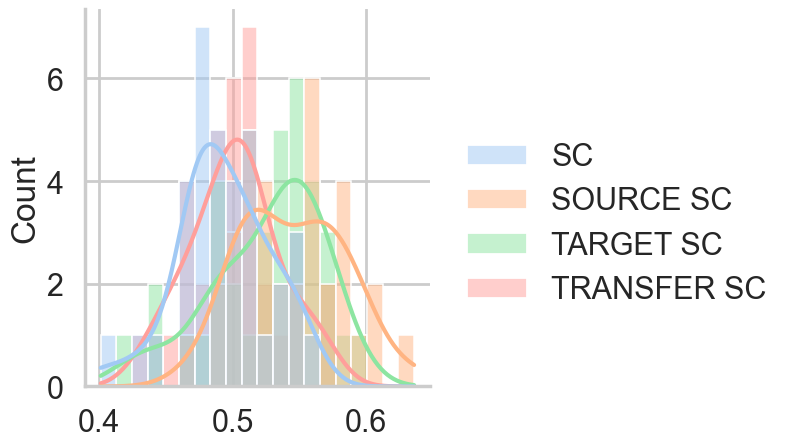

In [275]:
def overall_accs_report(weeks_to_train):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_acc_cat(A_test, Bs[week], test[week])[1])

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_acc_cat(A_test_target_only, Bs_only_target[week], test[week])[1])

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_acc_cat(A_test, Bs_tsc[week], test[week])[1])

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_acc_cat(A_test, Bs_only_target_from_target[week], test[week])[1])

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,
      'TRANSFER SC': tsc_res_list,
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(source_res_list), 3), round(np.mean(target_target_res_list), 3), round(np.mean(tsc_res_list), 3)

print(data_source)

sc, ssc, tarsc, tsc = overall_accs_report(weeks_to_train)
  

print('average DD accuracy on weeks for Mix SC', sc)
print('average DD accuracy on weeks for Source only SC, target only DD', ssc)
print('average DD accuracy on weeks for Target only SC and DD', tarsc)
print('average DD accuracy on weeks for Transfer SC', tsc)



average non-zero signal DD accuracy on weeks for Mix SC 0.696
average non-zero signal DD accuracy on weeks for Source only SC, target only DD 0.725
average non-zero signal DD accuracy on weeks for Target only SC and DD 0.685
average non-zero signal DD accuracy on weeks for Transfer SC 0.701


<Figure size 1500x1600 with 0 Axes>

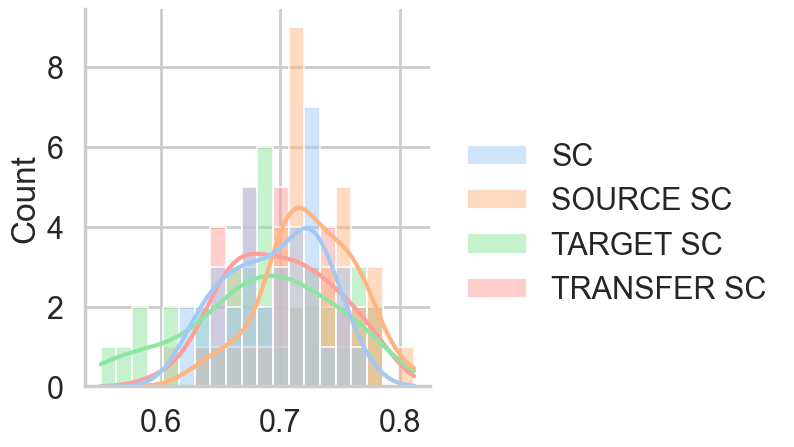

In [276]:
def overall_non_zero_accs_report(weeks_to_train):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_acc_cat_non_zero(A_test, Bs[week], test[week]))

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_acc_cat_non_zero(A_test_target_only, Bs_only_target[week], test[week]))

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_acc_cat_non_zero(A_test, Bs_tsc[week], test[week]))

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_acc_cat_non_zero(A_test, Bs_only_target_from_target[week], test[week]))

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,
      'TRANSFER SC': tsc_res_list,
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(source_res_list), 3), round(np.mean(target_target_res_list), 3), round(np.mean(tsc_res_list), 3)

print(data_source)

sc, ssc, tarsc, tsc = overall_non_zero_accs_report(weeks_to_train)
  

print('average non-zero signal DD accuracy on weeks for Mix SC', sc)
print('average non-zero signal DD accuracy on weeks for Source only SC, target only DD', ssc)
print('average non-zero signal DD accuracy on weeks for Target only SC and DD', tarsc)
print('average non-zero signal DD accuracy on weeks for Transfer SC', tsc)


##### Per category

In [252]:
def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_acc_per_category(A_test, Bs[week], test[week]))

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_acc_per_category(A_test_target_only, Bs_only_target[week], test[week]))

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_acc_per_category(A_test, Bs_tsc[week], test[week]))

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_acc_per_category(A_test, Bs_only_target_from_target[week], test[week]))

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,
      'TRANSFER SC': tsc_res_list,
      }
      )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average Mix SC error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in source_res_list]
      print('average Source only SC, target only DD error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in source_res_list]), 3)))
      errors_target = [d[cat][0] for d in target_target_res_list]
      print('average Target only SC and DD error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in target_target_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tsc_res_list]
      print('average Transfer SC error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc

print(data_source)

sc_cat, ssc_cat, tarsc_cat, tsc_cat = per_cat_accs_report(weeks_to_train)
  



average Mix SC error for fridge is 186.0 ratio is 0.085
average Source only SC, target only DD error for fridge is 197.0 ratio is 0.09
average Target only SC and DD error for fridge is 161.0 ratio is 0.073
average Transfer SC error for fridge is 197.0 ratio is 0.09


average Mix SC error for washing_drying is 259.0 ratio is 0.07
average Source only SC, target only DD error for washing_drying is 242.0 ratio is 0.065
average Target only SC and DD error for washing_drying is 236.0 ratio is 0.063
average Transfer SC error for washing_drying is 246.0 ratio is 0.066


average Mix SC error for computer_tv is 134.0 ratio is 0.07
average Source only SC, target only DD error for computer_tv is 155.0 ratio is 0.081
average Target only SC and DD error for computer_tv is 140.0 ratio is 0.074
average Transfer SC error for computer_tv is 145.0 ratio is 0.076


average Mix SC error for heating is 309.0 ratio is 0.054
average Source only SC, target only DD error for heating is 294.0 ratio is 0.051
ave

In [284]:
def per_cat_accs_report_non_zero(weeks_to_train):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_acc_per_category_non_zero(A_test, Bs[week], test[week]))

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_acc_per_category_non_zero(A_test_target_only, Bs_only_target[week], test[week]))

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_acc_per_category_non_zero(A_test, Bs_tsc[week], test[week]))

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_acc_per_category_non_zero(A_test, Bs_only_target_from_target[week], test[week]))

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,
      'TRANSFER SC': tsc_res_list,
      }
      )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average Mix SC non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in source_res_list]
      print('average Source only SC, target only DD non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in source_res_list]), 3)))
      errors_target = [d[cat][0] for d in target_target_res_list]
      print('average Target only SC and DD non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in target_target_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tsc_res_list]
      print('average Transfer SC non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc

print(data_source)

sc_cat, ssc_cat, tarsc_cat, tsc_cat = per_cat_accs_report_non_zero(weeks_to_train)



average Mix SC non-zero error for fridge is 184.0 ratio is 0.045
average Source only SC, target only DD non-zero error for fridge is 196.0 ratio is 0.048
average Target only SC and DD non-zero error for fridge is 161.0 ratio is 0.04
average Transfer SC non-zero error for fridge is 196.0 ratio is 0.049


average Mix SC non-zero error for washing_drying is 442.0 ratio is 0.106
average Source only SC, target only DD non-zero error for washing_drying is 431.0 ratio is 0.102
average Target only SC and DD non-zero error for washing_drying is 424.0 ratio is 0.101
average Transfer SC non-zero error for washing_drying is 438.0 ratio is 0.104


average Mix SC non-zero error for computer_tv is 135.0 ratio is 0.036
average Source only SC, target only DD non-zero error for computer_tv is 156.0 ratio is 0.042
average Target only SC and DD non-zero error for computer_tv is 141.0 ratio is 0.038
average Transfer SC non-zero error for computer_tv is 145.0 ratio is 0.039


average Mix SC non-zero error 

# Plotting functions

In [254]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [262]:
method_dict = {
    'SC mix, DD mix': (As, Bs),
    'SC source, DD target': (As_only_target, Bs_only_target),
    'SC target, DD target': (As_only_target_from_target ,Bs_only_target_from_target),
    'Transfer SC+DD': (As_tsc, Bs_tsc),
}
colors = ['orange', 'green', 'purple', 'red']

### Aggregate signal pred VS real plots

In [263]:
def get_all_agg_plots(data, nb_houses, nb_weeks, data_type='test'):
    figs, axes = [], []
    for week in range(nb_weeks):
        fig, ax = plt.subplots(figsize=(20, 20), nrows=nb_houses)
        plt.suptitle('Week {}'.format(week), fontsize=20)
        
        for house in range(nb_houses):
            xt = test[week]['X_bar']
            #for ind, cat in enumerate(all_categories):
            ax[house].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
            legend = []
            house_name = xt.columns[house]
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                legend.append(method)
                A_test = dsc.F_obj(x=data[week]['X_bar'].values, B=B[week],rp_gl=dsc.rp)
                abt = np.dot(B[week], A_test)
                ax[house].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
            ax[house].set_xlabel('Timestamp', fontsize=10)
            ax[house].set_ylabel('Consumption', fontsize=10)
            ax[house].set_title('DD for {} house {}, aggregate signal reconstruction'.format(data_type, house_name), fontsize=14)
            ax[house].legend(['real'] + legend)
        figs.append(fig)
        axes.append(ax)
        
    with PdfPages('plots/all_aggregate_plots_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)

            
            
def get_all_agg_plots_by_method(data, nb_houses, nb_weeks, data_type='test'):
    figs, axes = [], []
    for week in range(nb_weeks):        
        for house in range(nb_houses):
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            xt = test[week]['X_bar']
            house_name = xt.columns[house]
            plt.suptitle('Week {}, house {}'.format(week, house_name), fontsize=20)

            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                A_test = dsc.F_obj(x=data[week]['X_bar'].values, B=B[week],rp_gl=dsc.rp)
                abt = np.dot(B[week], A_test)
                ax[method_ind].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                ax[method_ind].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                ax[method_ind].set_xlabel('Timestamp', fontsize=10)
                ax[method_ind].set_ylabel('Consumption', fontsize=10)
                ax[method_ind].set_title('DD for {} house {}, method={}, aggregate signal reconstruction'.format(data_type, house_name, method), fontsize=14)
                ax[method_ind].legend(['real', 'predicted'])
            figs.append(fig)
            axes.append(ax)
        
    with PdfPages('plots/all_aggregate_plots_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)


In [264]:
nb_houses = test[0]['X_bar'].shape[1]
nb_houses

5

In [374]:
get_all_agg_plots(test, nb_houses, general_params['weeks_to_train'], data_type='test')

In [278]:
get_all_agg_plots_by_method(test, nb_houses, general_params['weeks_to_train'], data_type='test')

### Appliance signal pred VS real plots

In [266]:
def get_all_category_plots(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    for ind, cat in enumerate(appliance_categories):
        figs, axes = [], []
        for week in range(nb_weeks):
            fig, ax = plt.subplots(figsize=(20, 20), nrows=nb_houses)
            plt.suptitle('Week {}'.format(week), fontsize=20)

            for house in range(nb_houses):
                xt = test[week]['X'][appliance_categories[ind]]
                house_name = xt.columns[house]
                ax[house].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                legend = []
                for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                    B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]
                    A_test_app = dsc.F_obj(x=test[week]['X'][appliance_categories[ind]].values, B=B_test_app,rp_gl=general_params['rp'])
                    abt = np.dot(B_test_app, A_test_app)
                    
                    legend.append(method)
                    ax[house].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                ax[house].set_xlabel('Timestamp', fontsize=10)
                ax[house].set_ylabel('Consumption', fontsize=10)
                ax[house].set_title('DD for {} house {}, category={}'.format(data_type, house_name, cat), fontsize=14)
                ax[house].legend(['real'] + legend)
            figs.append(fig)
            axes.append(ax)

        with PdfPages('plots/all_{}_plots_{}_{}.pdf'.format(cat, data_type, data_source)) as pdf:
            for fig in figs:
                pdf.savefig(fig)

            
            
def get_all_category_plots_by_method(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    for ind, cat in enumerate(appliance_categories):
        figs, axes = [], []
        for week in range(nb_weeks):            
            for house in range(nb_houses):
                
                fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
                xt = test[week]['X'][appliance_categories[ind]]
                house_name = xt.columns[house]
                plt.suptitle('Week {}, house {}'.format(week, house_name), fontsize=20)

                for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                    
                    B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]

                    A_test_app = dsc.F_obj(x=test[week]['X'][cat].values, B=B_test_app,rp_gl=general_params['rp'])
                    abt = np.dot(B_test_app, A_test_app)                    
                    
                    ax[method_ind].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                    ax[method_ind].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                    ax[method_ind].set_xlabel('Timestamp', fontsize=10)
                    ax[method_ind].set_ylabel('Consumption', fontsize=10)
                    ax[method_ind].set_title('DD for {} house {}, method={}, category={}'.format(data_type, house_name, method, cat), fontsize=14)
                    ax[method_ind].legend(['real', 'predicted'])
                figs.append(fig)
                axes.append(ax)
        
        with PdfPages('plots/all_{}_plots_by_method_{}_{}.pdf'.format(cat, data_type, data_source)) as pdf:
            for fig in figs:
                pdf.savefig(fig)


In [96]:
get_all_category_plots(test, nb_houses, general_params['weeks_to_train'], data_type='test')


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x12b98ea60> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x162980160> (for post_execute):



KeyboardInterrupt



In [277]:
get_all_category_plots_by_method(test, nb_houses, general_params['weeks_to_train'], data_type='test')

### Pie Chart of consumption

In [268]:
from collections import defaultdict

In [269]:
def get_consumption_pie_chart(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    figs, axes = [], []
    for week in range(nb_weeks):
        consumption_dict = defaultdict(dict)
        real_consumption_dict = defaultdict(dict)
        for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
            A = np.asarray(A)
            B = np.asarray(B)
            
            consumption_dict[method]['aggregate'] = data[week]['X_bar'].mean(axis=0).values
            real_consumption_dict[method]['aggregate'] = consumption_dict[method]['aggregate']
            for ind, cat in enumerate(appliance_categories):
                
                B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]

                A_test_app = dsc.F_obj(x=test[week]['X'][cat].values, B=B_test_app,rp_gl=general_params['rp'])
                abt = np.dot(B_test_app, A_test_app)                    

                #A_test = dsc.F_obj(x=data[week]['X_bar'].values, B=B[week],rp_gl=dsc.rp)
                #abt = np.dot(B[week], A_test)
                consumption_dict[method][cat] = abt.mean(axis=0)
                
                real_consumption_dict[method][cat] = data[week]['X'][cat].mean(axis=0).values
                
                
        for house in range(nb_houses):
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())), ncols=2)
            house_name = data[week]['X'][cat].columns[house]
            plt.suptitle('Week {}, {} house {}'.format(week, data_type, house_name), fontsize=20)
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                # Predicted pie chart
                values = [consumption_dict[method][cat][house] for cat in appliance_categories]
                noise = consumption_dict[method]['aggregate'][house] - sum(values)
                if noise < 0:
                    noise = 0
                values.append(noise)
                ax[method_ind, 0].pie(values, labels=appliance_categories + ['noise'], autopct='%1.1f%%')
                ax[method_ind, 0].set_title('predicted, {}'.format(method))

                # Real pie chart
                real_values = [real_consumption_dict[method][cat][house] for cat in appliance_categories]
                real_noise = real_consumption_dict[method]['aggregate'][house] - sum(real_values)
                if real_noise < 0:
                    real_noise = 0
                real_values.append(real_noise)
                ax[method_ind, 1].pie(real_values, labels=appliance_categories + ['noise'], autopct='%1.1f%%')
                ax[method_ind, 1].set_title('real, {}'.format(method))

            figs.append(fig)
            axes.append(ax)

    with PdfPages('plots/pie_charts_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)



In [279]:
get_consumption_pie_chart(test, nb_houses, general_params['weeks_to_train'], data_type='test')

### Basis functions

In [271]:
def plot_bases(data, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    figs, axes = [], []
    for ind, cat in enumerate(appliance_categories):
        for week in range(nb_weeks):            
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            plt.suptitle('Week {}'.format(week), fontsize=20)
            xt = test[week]['X'][appliance_categories[ind]]
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):

                B_test_app = B[week][:,ind*n_components:(ind+1)*n_components].T

                ax[method_ind].imshow(B_test_app, cmap='gray')
                ax[method_ind].set_title('Learned Basis functions, method={}, category={}'.format(method, cat), fontsize=14)
            figs.append(fig)
            axes.append(ax)
        
        with PdfPages('plots/basis_functions_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
            for fig in figs:
                pdf.savefig(fig)

In [280]:
plot_bases(test, general_params['weeks_to_train'], data_type='test')

### Noise signal pred VS real plots

In [273]:
def get_noise(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    figs, axes = [], []
    for week in range(nb_weeks):
        pred_noise = dict()
        real_noise = dict()
        for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
            A = np.asarray(A)
            B = np.asarray(B)

            pred_noise[method] = data[week]['X_bar'].values
            real_noise[method] = data[week]['X_bar'].values
            for ind, cat in enumerate(appliance_categories):
                B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]
                A_test_app = dsc.F_obj(x=test[week]['X'][cat].values, B=B_test_app,rp_gl=general_params['rp'])
                abt = np.dot(B_test_app, A_test_app)   
                pred_noise[method] = pred_noise[method] - abt
                real_noise[method] = real_noise[method] - data[week]['X'][cat].values
                
        for house in range(nb_houses):
            house_name = data[week]['X_bar'].columns[house]
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            plt.suptitle('Week {}, {} house {}'.format(week, data_type, house_name), fontsize=20)
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                
                
                ax[method_ind].plot([i*100 for i in range(len(real_noise[method]))], real_noise[method][:,house], c='blue', alpha=0.5)
                ax[method_ind].plot([i*100 for i in range(len(real_noise[method]))], pred_noise[method][:,house], c=colors[ind], alpha=0.5)
                ax[method_ind].set_xlabel('Timestamp', fontsize=10)
                ax[method_ind].set_ylabel('Consumption', fontsize=10)
                ax[method_ind].set_title('DD noise for {} house {}, method={}, category={}'.format(data_type, house_name, method, cat), fontsize=14)
                ax[method_ind].legend(['real', 'predicted'])

            figs.append(fig)
            axes.append(ax)

    with PdfPages('plots/noise_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)



In [281]:
get_noise(test, nb_houses, general_params['weeks_to_train'], data_type='test')